# Intro:

This notebook is the second in the series for the Capstone Project.  "Capstone_Data-Prep" covers pulling in several
data sources, trimming to the needed observations/variables, joining together, and producing the source data or this
notebook.

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json
import math
import statsmodels.formula.api as smf

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

#sklearn Data Prep:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#sklearn Imputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# SkLearn Measurement Libraries:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_blobs
from sklearn import ensemble


# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [2]:
# Set Paths
path = os.getcwd()
sourceDataPath = path + '\\CleanData\\'
exportPath = path +'\\Export\\'
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/'

# set plot export paths:

print(f"Source Data:",sourceDataPath)
print(f"Exports:",exportPath)
print(f"Plots:",plotLoc)

Source Data: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\CleanData\
Exports: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\Export\
Plots: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/


# Reusable Functions:

In [3]:
#statRow = []
cleanActionsDF = pd.DataFrame(columns = ['DF','ActionDesc','List-of-Cols','ResultShape'])

def cleanActionsReport (df,df_name,actionDesc, cols):
    # Collect Stats
    row =[]
    actionDesc = actionDesc
    listCols = cols
    resultShape = df.shape
    # Collect Results
    row = [df_name,actionDesc, listCols, resultShape]
    # append stats to Summary Stats DF
    df = cleanActionsDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [4]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per",
                                             "Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [5]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df,scaleList):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in scaleList:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = round(df_std[column],5)
    return df_std

In [6]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [7]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    #new section
    #old section
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt

# Source: https://medium.com/@gaurav_bio/making-sense-of-real-world-data-roc-curves-and-when-to-use-them-90a17e6d1db

In [8]:
# Create DF for Capturing Model Results
statRow = []
qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

def OLD_quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        qe_summaryDF = summaryStats(model_name,qe_y_test, y_pred_qe, qe_summaryDF)
        # PLOT ROC curve -- TODO
    return qe_summaryDF

In [9]:
# Create DF for Capturing Model Results
statRow = []
qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

def quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        row =[]
        accuracy = round(accuracy_score(qe_y_test, y_pred_qe),4)
        precision = round(precision_score(qe_y_test, y_pred_qe),4)
        recall = round(recall_score(qe_y_test, y_pred_qe),4)
        f1 = round(f1_score(qe_y_test, y_pred_qe),4)
        cm = confusion_matrix(y_test, y_pred_qe)
        # Collect Results
        row = [model_name,accuracy, precision, recall, f1,cm]
        # append stats to Summary Stats DF
        df = qe_summaryDF
        df_length = len(df)
        df.loc[df_length] = row
    return qe_summaryDF

In [10]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [11]:
statRow = []
summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

# Takes test and predicted sets and returns precision/recall metrics
def summaryStats (model_name, y_test, y_pred, SummaryDF):
    # Collect Stats
    row =[]
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    cm = confusion_matrix(y_test, y_pred)
    #cm = confusion_matrix(y_test, y_pred)
    #probas = model.predict_proba(roc_x_test) # get the probability distribution
    #fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    #roc_auc = auc(fpr, tpr) # get area under curve
    # Collect Results
    row = [model_name,accuracy,precision, recall, f1,cm]
    # append stats to Summary Stats DF
    df = SummaryDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [12]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [13]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [14]:
def grid_search_wrapper(refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(x_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [15]:
def prepVarsForMLR(df, dependent_var,*varsToRemove):
    columns = list(df.columns.values)
    columns.remove(dependent_var)
    for col in varsToRemove:
        columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(columns)

In [16]:
#guide: https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4
# TODO: Add F_Stastic
# Take P_Value of the F-static

def backwardElimination(df,respVar,signLevel):
    origFeatList = df.columns.values.tolist()
    origFeatList.remove(respVar)
    # Create df for significant features:
    signFeatDF = pd.DataFrame(columns = ['feature','pvalue'])
    ##### Start Loop ########
    x = df.shape[1]
    while x > 0:
        tempdf = df
        # For feature in list of features get p
        listofVars = prepVarsForMLR(tempdf,respVar) # Prep Vars for OLS p-value:
        ols = smf.ols(formula=listofVars, data=df).fit() # fit model
        # get pvalues
        ## Make DF w/ P Values
        pvalueDF = pd.DataFrame(ols.pvalues).reset_index()
        pvalueDF = pvalueDF.rename(columns={'index':'feature',0:'pvalue'})
        pvalueDF = pvalueDF.iloc[1: , :] ## Drop first Row which is always the intercept
        ## Select Feature w/ Highest P-Value
        checkmaxP = pvalueDF['pvalue'].max()
        ## If PValue is greater that Sign-Level
        if checkmaxP >= signLevel:
            # Add Feature/PValue to SignFeatureDF
            maxP = pvalueDF[pvalueDF.pvalue == pvalueDF.pvalue.max()]
            signFeatDF = pd.concat([signFeatDF,maxP], ignore_index=True)
            # Remove Feature From DF
            varToRemove = maxP['feature'].values.tolist() #get feature name as a string to remove
            df = df.drop(columns=varToRemove)
            # Update x
            x=x-1
        else:
            x=0
            nonsignFeatList = pvalueDF['feature'].values.tolist()
    return signFeatDF, nonsignFeatList

# Get and Prep Data

In [17]:
# Get Source Data
file = 'completeDF.csv'
origDF = pd.read_csv(sourceDataPath+file,skipinitialspace = True)
origDF = origDF.drop(columns=['Unnamed: 0'])
origDF.shape

(348, 165)

In [18]:
nullAnalysisDF = nullAnalysis(origDF)
nullAnalysisDF


Count of Variables: 165
Count of Variables without nulls: 43
Count of Variables with null : 122


Variable Observations Nulls  Null_Per Num_Unique     Type
164  SettlementAmount          348   302    86.782         12  float64
141          xacc_std          348    83    23.851        257  float64
65          esubc_std          348    73    20.977         70  float64
140              xacc          348    50    14.368        284  float64
79          intpn_std          348    49    14.080        276  float64
..                ...          ...   ...       ...        ...      ...
114              pstk          348     1     0.287         49  float64
110             ppegt          348     1     0.287        328  float64
48              dpact          348     1     0.287        326  float64
18                ceq          348     1     0.287        347  float64
86                lct          348     1     0.287        346  float64

[122 rows x 6 columns]

In [19]:
# Set aside variables that may be valuable for looks/interpretation of results, but not modeling
orig_lookUps = origDF[['gvkey','tic','curncd','currtr']].copy()

# delete those from origDF
origDF = origDF.drop(columns=['tic','curncd','currtr'])
orig_lookUps.head(3)

gvkey   tic curncd  currtr
0   1239   ACV    USD     1.0
1   1266  ALCO    USD     1.0
2   1408  BEAM    USD     1.0

In [20]:
# Scale Data -- Create List for Scaling

## Create list of exceptions for scaling
scaleException = ['gvkey','exesign','src','auop','rest_count','rest_count_of_diffs',
                  'st_per_growth','st_per_currentToMax','st_per_lowToStart','st_volatility','rat_spcsrc',
                  'lawsuit','SettlementAmount',
                  'invch']

# Parking Lot: 'rest_a_count_of_diffs'

## Remove exceptions from scale list
orig_scaleList = origDF.columns.tolist()
for col in scaleException:
    orig_scaleList.remove(col)

# Scale Data -- Call the z_score function
origDF_scaled = z_score(origDF,orig_scaleList)
origDF_scaled.sample(3)

gvkey  exesign  src  auop  gsubind   aoloch  aoloch_std       at  \
304  185083        1    5     2 -1.76318 -0.05664    -0.39700 -0.33707   
11     2606        1    5     1 -0.19186 -0.05292    -0.39960 -0.33381   
206  105104        0    3     1 -1.76302 -1.18499     1.12918  0.52774   

      at_std   bkvlps  ...  st_volatility  sec_ajexm  sec_ajpm  sec_trfm_mean  \
304 -0.38055 -0.07864  ...           1.29   -0.12927  -0.12920       -0.30114   
11  -0.38177 -0.07859  ...           0.53   -0.12927  -0.12920       -0.23784   
206  0.07684 -0.07861  ...           0.21   -0.08695  -0.08689       -0.24609   

     sec_trfm_std  sec_trt1m_mean  sec_trt1m_std  rat_spcsrc  lawsuit  \
304      -0.06434        -0.18005       -0.12759         0.0      0.0   
11       -0.22835         0.14980        0.16739         1.0      0.0   
206      -0.18510        -0.12978       -0.14854         0.0      1.0   

     SettlementAmount  
304               NaN  
11                NaN  
206               0.0  

[3 rows x 162 columns]

In [21]:
#Imputer 1 - Prep DF for Imputer
## Used as a guide, which states that ExtraTreesRegressor performs best:
## https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505
## Further Documentation: https://scikit-learn.org/stable/modules/impute.html#impute

## Create DF w/o response Vars and a temp to rejoin after imputer runs
completeDF_Imputed = origDF_scaled.copy()
temp_Imputed_Resp = completeDF_Imputed[['gvkey','lawsuit','SettlementAmount']]
completeDF_Imputed = completeDF_Imputed.drop(columns=['lawsuit','SettlementAmount'])
temp_Imputed_Resp.head(3)

gvkey  lawsuit  SettlementAmount
0   1239      1.0               0.0
1   1266      0.0               NaN
2   1408      0.0               NaN

In [22]:
# Imputer 2 - Run Imputer & Rejoin Temp Data

print("Starting Imputer...")

# Introduce IterativeImputer with an estimator and Fit
imp = IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=42)
imp.fit(completeDF_Imputed)

# Transform the dataset containing missing values
completeDF_Imputed = pd.DataFrame(imp.transform(completeDF_Imputed), columns = completeDF_Imputed.columns)
print("Done w/ Imputer")

# Rejoin Temp - Check Shape, should be 348, 164
completeDF_Imputed = completeDF_Imputed.merge(temp_Imputed_Resp, left_on='gvkey', right_on='gvkey')
completeDF_Imputed.shape

Starting Imputer...
Done w/ Imputer


(348, 162)

In [23]:
# Fix Features That Should be Int w/o decimals
cols = ['gvkey','exesign','src','auop','rat_spcsrc','lawsuit']
completeDF_Imputed[cols] = completeDF_Imputed[cols].astype(int)

# Clean Actions Report -- Drop gsubind (Only kept to inform Imputing)
cleanActionsDesc = "Drop gsubind (Only kept to inform Imputing)."
df_name = "CompleteDF"

colsToDrop = ['gsubind']

completeDF_Imputed = completeDF_Imputed.drop(columns=colsToDrop)
cleanActionsReport(completeDF_Imputed,df_name,cleanActionsDesc,colsToDrop)

completeDF_Imputed.sample(3)

gvkey  exesign  src  auop   aoloch  aoloch_std       at   at_std  \
177  61763        1    5     1 -0.07370    -0.30982 -0.28842 -0.30954   
7     1920        1    5     1  0.07593     0.28946  0.05506 -0.05122   
73   10871        1    5     2 -0.05600    -0.39984 -0.33837 -0.38273   

      bkvlps  bkvlps_std  ...  st_volatility  sec_ajexm  sec_ajpm  \
177 -0.07853    -0.07690  ...           0.30   -0.12927   -0.1292   
7   -0.07862    -0.07691  ...           0.28   -0.12927   -0.1292   
73  -0.07865    -0.07692  ...           0.67   -0.12927   -0.1292   

     sec_trfm_mean  sec_trfm_std  sec_trt1m_mean  sec_trt1m_std  rat_spcsrc  \
177       -0.29814      -0.22835        -0.12535       -0.14193           3   
7          1.15449       0.19986        -0.14119       -0.14596           3   
73        -0.29814      -0.22835        -0.14384       -0.04726           0   

     lawsuit  SettlementAmount  
177        0               NaN  
7          1               0.0  
73         0               NaN  

[3 rows x 161 columns]

In [24]:
# Check Result Nulls
nullAnalysisDF = nullAnalysis(completeDF_Imputed)
nullAnalysisDF


Count of Variables: 161
Count of Variables without nulls: 160
Count of Variables with null : 1


Variable Observations Nulls  Null_Per Num_Unique     Type
160  SettlementAmount          348   302    86.782         12  float64

# LawSuit Modeling

Note to self: In my process, before I ran this section I ran the "Feature Selection" section to trim the
feature list.  That section is archived below, but it made sense to place it below this modeling section
because I did not need to re-run.  The results are saved in the "Export" directory and were used to produce
the feature list at the top of this section.

In [25]:
# Create DF for Capturing Model Results
statRow = []
summaryStatsDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

# Create Lawsuit Modeling DF
ls_Modeling = completeDF_Imputed.copy()
print(ls_Modeling.shape)
ls_Modeling.sample(3)

(348, 161)


gvkey  exesign  src  auop   aoloch  aoloch_std       at   at_std  \
163   30443        1    5     1 -0.06601    -0.36587 -0.20696 -0.36282   
132   21506        1    3     1 -0.05517    -0.39849 -0.33796 -0.38225   
256  164408        1    5     1 -0.05152    -0.39283 -0.30711 -0.30143   

      bkvlps  bkvlps_std  ...  st_volatility  sec_ajexm  sec_ajpm  \
163 -0.07843    -0.07691  ...           0.11   -0.12927   -0.1292   
132 -0.07865    -0.07692  ...           0.45   -0.12927   -0.1292   
256 -0.07861    -0.07692  ...           0.50   -0.12927   -0.1292   

     sec_trfm_mean  sec_trfm_std  sec_trt1m_mean  sec_trt1m_std  rat_spcsrc  \
163       -0.25522      -0.19302        -0.12929       -0.15247           4   
132        0.38800       0.17156        -0.11157       -0.14933           6   
256       -0.29814      -0.22835        -0.11615       -0.13649           0   

     lawsuit  SettlementAmount  
163        0               NaN  
132        0               NaN  
256        1               0.0  

[3 rows x 161 columns]

## LawSuit Modeling -- Feature Selection and Prepare Data

Process:
* Check Correlation w/ Response Var
* TODO: Check Collinearity
* Use RF/GB Feature Importance
* Create Resulting Feature List

### LawSuit Modeling -- Feature Selection -- Check Correlation

In [26]:
# Feature Selection -- Check Correlation -- Correlation with output variable
responseVar = 'lawsuit'
cor = round(ls_Modeling.corr(),3)
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
nonRelevant_features = cor_target[cor_target<0.05] # Look for Features w/ less 0.05 cor
nonRelevant_features

exesign              0.044
aoloch_std           0.043
bkvlps               0.036
bkvlps_std           0.038
caps_std             0.016
chech                0.006
ci_std               0.025
cibegni_std          0.033
cshpri_std           0.001
dcpstk               0.016
defrev               0.003
defrev_std           0.024
dvc                  0.040
dvt                  0.039
epsfi                0.026
epsfi_std            0.002
epsfx                0.025
epsfx_std            0.008
epspi                0.026
epspi_std            0.002
esopct               0.000
esopct_std           0.018
esubc                0.021
esubc_std            0.026
fincf_std            0.016
fopo                 0.028
gdwl                 0.029
gdwl_std             0.012
intan                0.026
intan_std            0.002
mii                  0.005
mii_std              0.024
msa                  0.021
msa_std              0.025
ni_std               0.034
nopi_std             0.010
oancf_std            0.038
o

In [27]:
## Feature Selection -- Check Correlation -- Trim DF to Relevant Features

# List of features to drop
nonRelevant_features = nonRelevant_features.index.values.tolist()
# Override
overrideCols = ['st_per_growth','sec_ajpm']
for col in overrideCols:
    nonRelevant_features.remove(col)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.05 corr while making sure to have 1 feature per source"
df_name = "CompleteDF"

ls_Modeling_relFeat = ls_Modeling.drop(columns=nonRelevant_features)
cleanActionsReport(completeDF_Imputed,df_name,cleanActionsDesc,nonRelevant_features)

# Resulting DF
print(ls_Modeling_relFeat.shape)
ls_Modeling_relFeat.sample(3)



(348, 105)


gvkey  src  auop   aoloch       at   at_std     caps     capx  capx_std  \
211  111961    5     2 -0.46948 -0.23345  0.08549  0.09243 -0.26925  -0.41166   
53     8582    5     1 -0.14964 -0.29967 -0.36554 -0.19816 -0.25774  -0.41653   
309  185699    5     1 -0.04536 -0.32566 -0.34285 -0.20062 -0.22496  -0.24384   

         ceq  ...  rest_count_of_diffs  st_per_growth  st_per_currentToMax  \
211 -0.27836  ...                 17.0          -1.00                 0.00   
53  -0.26067  ...                 11.0           0.26                 0.76   
309 -0.27602  ...                  0.0          -0.68                 0.31   

     st_volatility  sec_ajpm  sec_trt1m_mean  sec_trt1m_std  rat_spcsrc  \
211           0.91   -0.1292        -0.23141       -0.11680           1   
53            0.13   -0.1292        -0.12892       -0.14518           3   
309           0.39   -0.1292        -0.15070       -0.14318           0   

     lawsuit  SettlementAmount  
211        0               NaN  
53         0               NaN  
309        0               NaN  

[3 rows x 105 columns]

###  LawSuit Modeling -- Feature Selection -- Use Rand Forest/ GradBoost Feature Importance
* Creates a Test/Train Split (Will Resplit from Source After Feature Selection)
* Then uses Random Forest and Grad Boost for Feature Importance
* Results reflected in feature lists for model and stored as reports
and plots in the export directory


In [28]:
# Prepare For Feature Selection
## Feature Selection Will Use Lawsuit - so drop SettlementAmount
ls_Modeling_relFeat = ls_Modeling_relFeat.drop(columns='SettlementAmount')

## Set gvkey as index
ls_Modeling_relFeat.set_index('gvkey')
print(f"Shape:",ls_Modeling_relFeat.shape)
ls_Modeling_relFeat.sample(3)


Shape: (348, 104)


gvkey  src  auop   aoloch       at   at_std     caps     capx  capx_std  \
197   65459    5     2  0.03427 -0.13996  0.12080  0.09634 -0.23030  -0.21980   
146   25536    5     1 -0.02503 -0.27908 -0.36686 -0.12979 -0.24761  -0.38129   
241  154984    5     1 -0.05544 -0.33838 -0.38274 -0.21841 -0.27988  -0.46306   

         ceq  ...  rest_sum_diff  rest_count_of_diffs  st_per_growth  \
197 -0.17847  ...       -0.04725                  4.0         2.8700   
146 -0.24588  ...       -0.12621                  4.0        -0.1600   
241 -0.30456  ...       -0.13080                  0.0         3.1392   

     st_per_currentToMax  st_volatility  sec_ajpm  sec_trt1m_mean  \
197               0.9600         0.4200 -0.129200       -0.112810   
146               0.6800         0.1500 -0.129200       -0.133680   
241               0.4958         0.6683 -0.001054       -0.002736   

     sec_trt1m_std  rat_spcsrc  lawsuit  
197      -0.144460           1        0  
146      -0.144450           3        0  
241      -0.024684           0        0  

[3 rows x 104 columns]

In [29]:
# Set or Reset Test/Train Split
# Params
df=ls_Modeling_relFeat
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (278, 103)
x_test shape: (70, 103)


In [30]:
#TODO - check params with .get_params
# maybe add ration and check knn
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')


*******************************************************************************
Before Balancing:
x_train shape:  (278, 103)
y_train shape:  (278,)
x_test shape:  (70, 103)
y_test shape:  (70,)

y_train value counts: 0    243
1     35
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 103)
y_train shape:  (486,)
x_test shape:  (70, 103)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


### Feature Selection -- Random Forest

In [31]:
print("starting RF")
# Random Forest
## Set and Fit Model
## Note: Params from gridSearchCV optimized for recall w/ all features
rf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=96, min_samples_split=2, max_depth=5,
                            max_features='sqrt',criterion='gini',n_jobs=-1)


rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


start plot


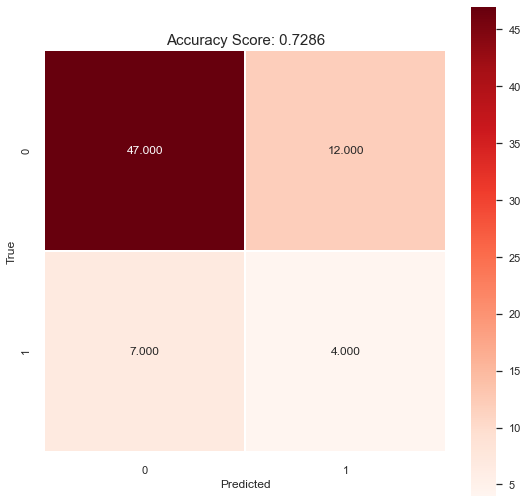

In [32]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_LS_FeatSelect.png')

In [33]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest-Feature Selection-Tune=Recall"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0  Random Forest-Feature Selection-Tune=Recall    0.7286       0.25  0.3636   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]

Start RF ROC Plot


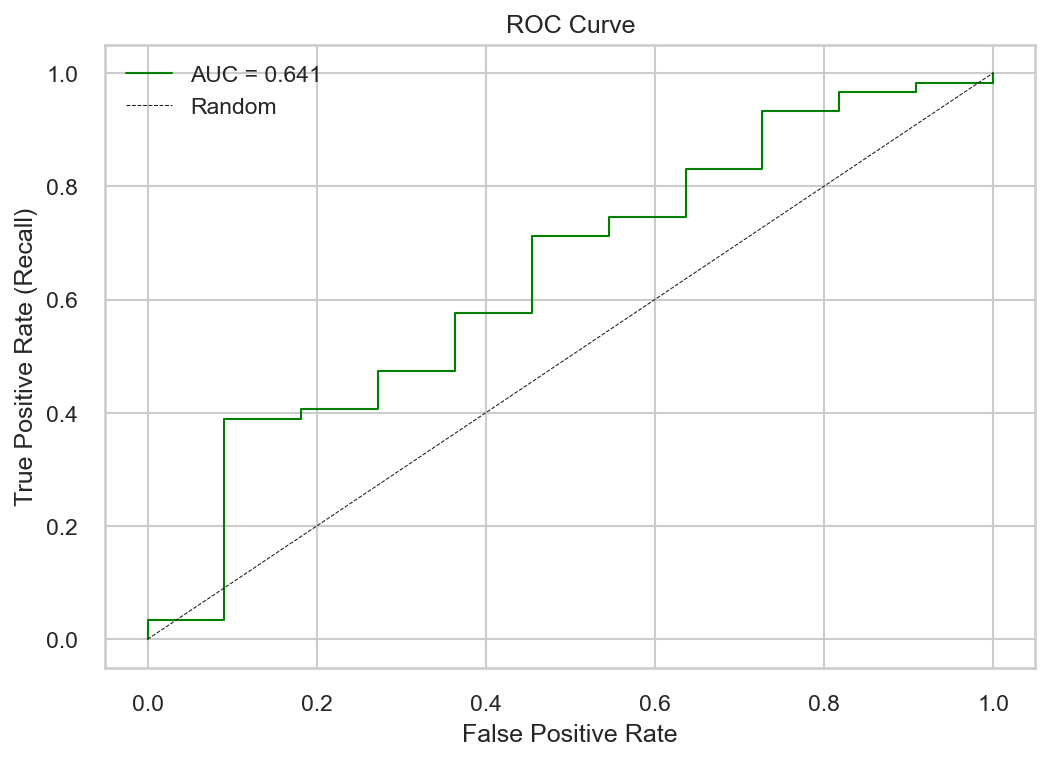

In [34]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
#plt.savefig(plotLoc+'RF_ROC.png')

Start RF Feature Importance


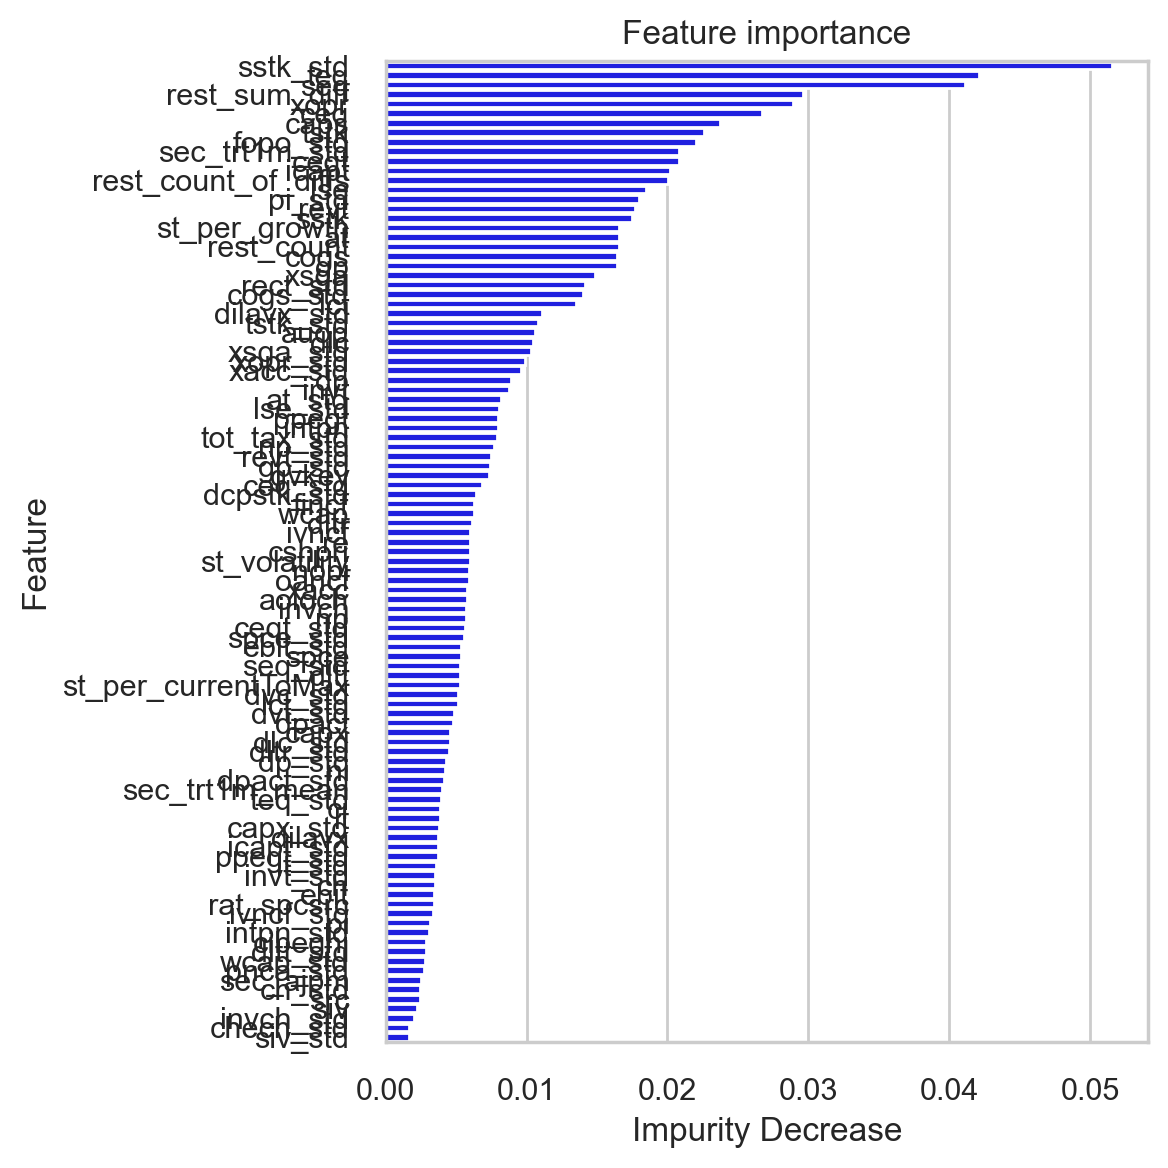

In [35]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_LS_FeatSelect.png')

### Feature Selection -- Gradient Boosting

In [36]:
print("starting GB")
## Setting when optimized for Accuracy
## Note: Params from gridSearchCV optimized for recall w/ all features
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.99,random_state=1,
                                max_depth=3, min_samples_split=75, max_features=8)

gb.fit(x_train,y_train)

## Make Predictions
y_pred_gb = gb.predict(x_test)
print("done predict gb")

starting GB
done predict gb


start gb plot


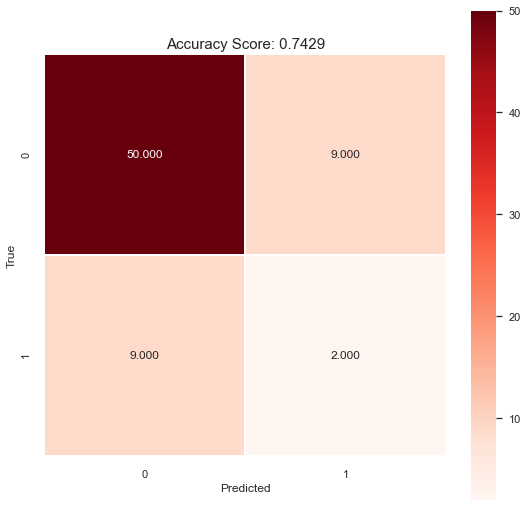

In [37]:
print("start gb plot")
cm, score = createConfMatrix(gb,y_test, y_pred_gb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GB_CM_LS_FeatSelect.png')

In [38]:
#  GB -- Precision/Recall Scores

## Set Params
model_name = "Gradient Boost-FeatureSelection-Tune=Recall"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0  Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1  Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]

Start GB ROC Plot


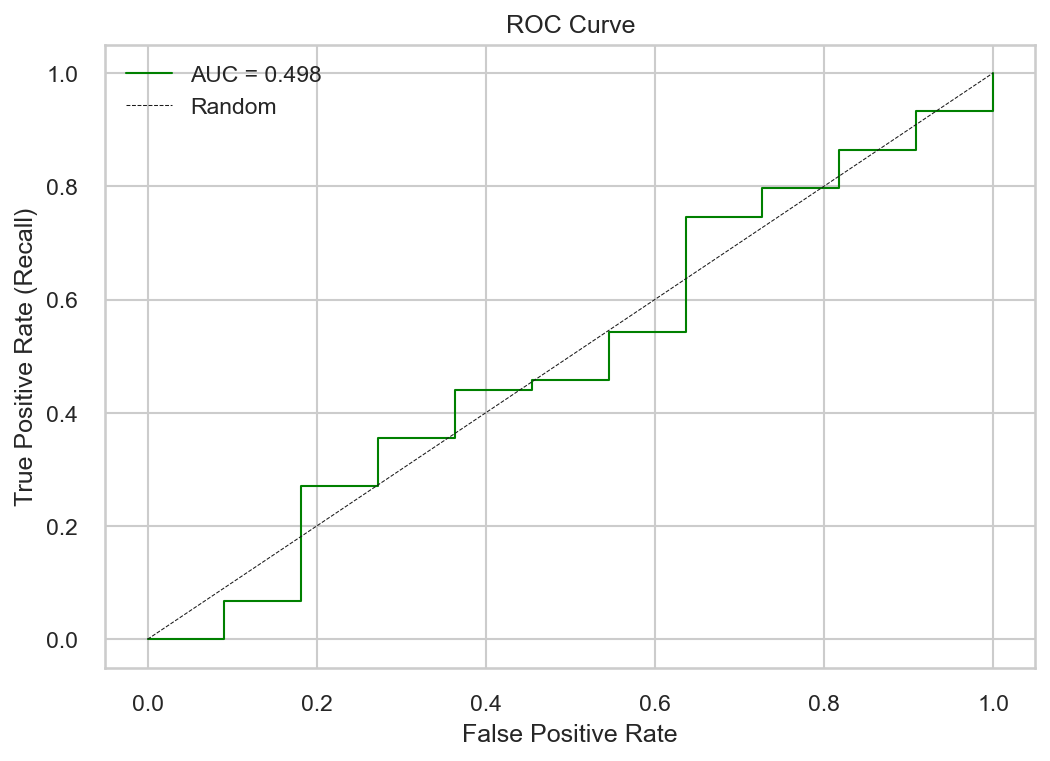

<Figure size 576x396 with 0 Axes>

In [39]:
# ROC Curve/ AUC Score
print("Start GB ROC Plot")

## Call Function
ROC_Curve_Plot(gb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GB_ROC_LS_FeatSelect.png')

Start GB Feature Importance


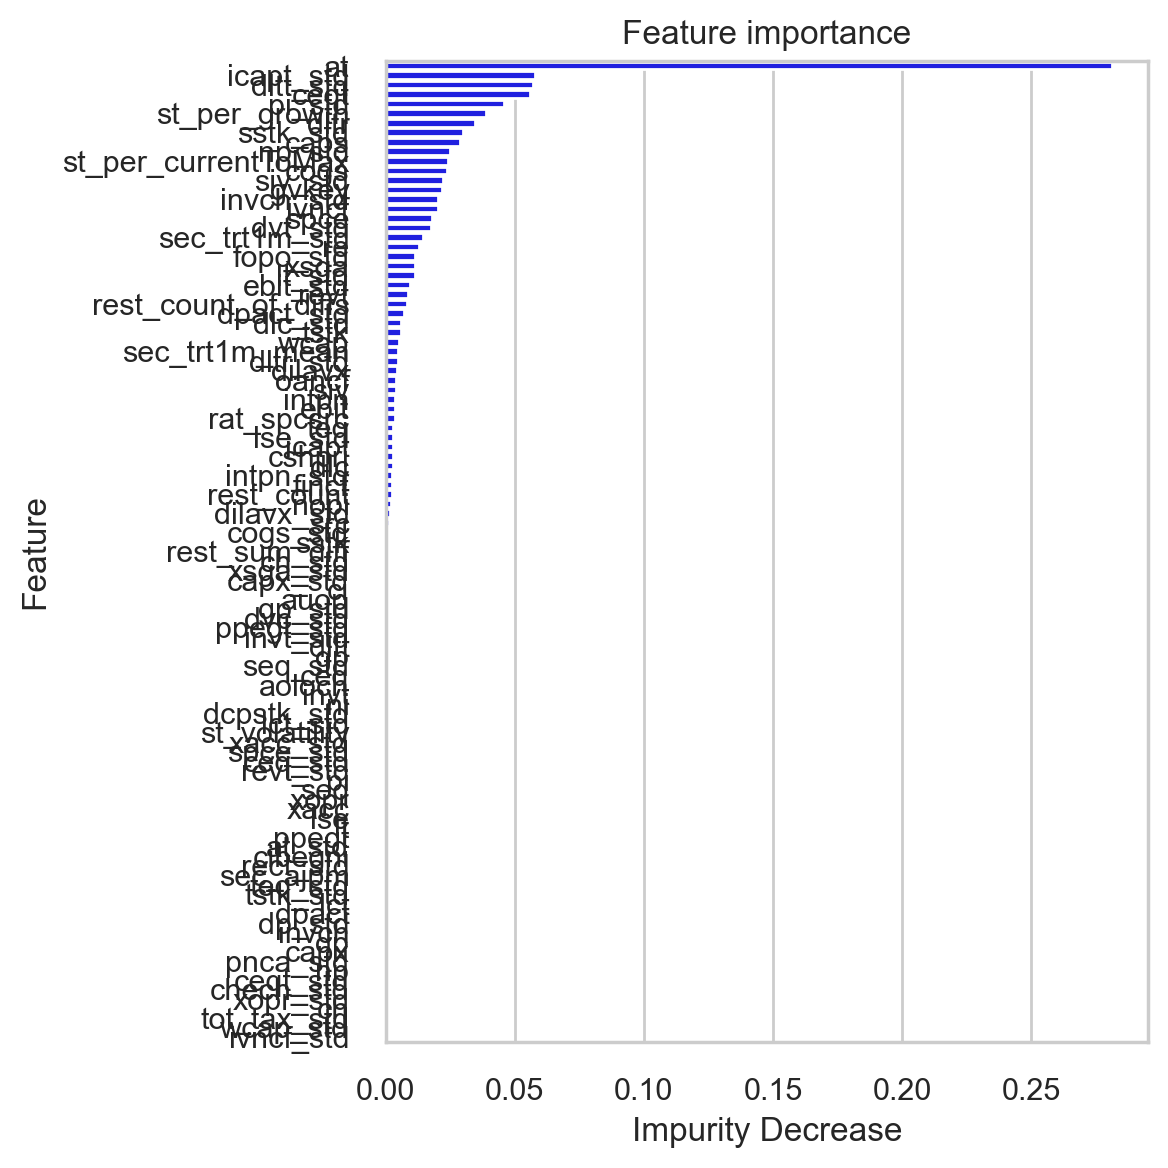

In [40]:
# Gradiant Boost -- Feature Importance -- Plot Most Important Features
print("Start GB Feature Importance")

feature_importances, fig = FeatureImportance(gb,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'GB__LS_FeatSelect.png')

In [41]:
## Combined Feature Importance Plot

rf_importances = rf.feature_importances_
rf_forest_importances = pd.Series(rf_importances, index=featureList)
rf_forest_importances = rf_forest_importances.to_frame().reset_index()
rf_forest_importances = rf_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
rf_forest_importances = rf_forest_importances.sort_values(by='impDecrease',ascending=False)
rf_forest_importances['Model'] = "Random Forest"

gb_importances = gb.feature_importances_
gb_forest_importances = pd.Series(gb_importances, index=featureList)
gb_forest_importances = gb_forest_importances.to_frame().reset_index()
gb_forest_importances = gb_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
gb_forest_importances = gb_forest_importances.sort_values(by='impDecrease',ascending=False)
gb_forest_importances['Model'] = "Gradient Boosting"
feature_importances_comb = rf_forest_importances.append(gb_forest_importances, ignore_index=True)

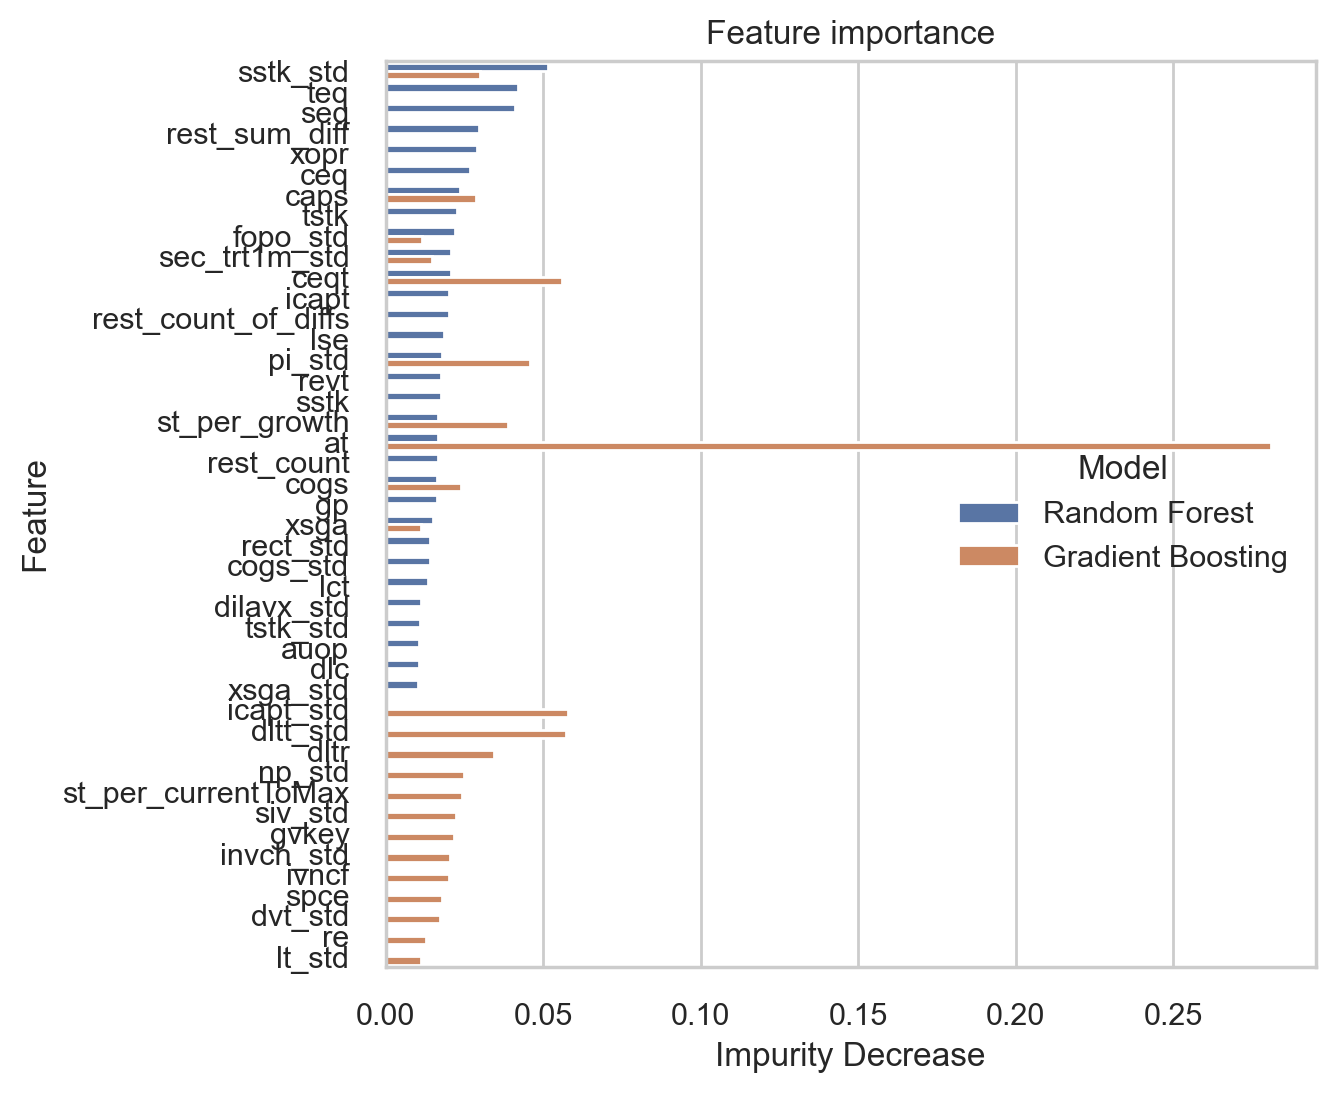

In [42]:
# drop these row indexes
# from dataFrame
index_names = feature_importances_comb[feature_importances_comb['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances_comb.drop(index_names, inplace = True)
feature_importances_comb

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", hue="Model",
                  data=feature_importances_comb)
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')

In [43]:
# Tmp (Possible -- Drop GB Feature Importance since RF was much better w/ Recall)
feature_importances_RFONLY = rf_forest_importances
feature_importances_RFONLY = feature_importances_RFONLY[feature_importances_RFONLY['impDecrease'] >= 0.01 ]

featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
feature_importances_RFONLY = feature_importances_RFONLY.append(featImport_ManAppend,ignore_index=True)
feature_importances_RFONLY.to_excel(exportPath+"FeatureSelection_LawSuit_RFONLY.xlsx")
feature_importances_RFONLY

feature  impDecrease            Model
0              sstk_std     0.051521    Random Forest
1                   teq     0.042109    Random Forest
2                   seq     0.041135    Random Forest
3         rest_sum_diff     0.029641    Random Forest
4                  xopr     0.028942    Random Forest
5                   ceq     0.026733    Random Forest
6                  caps     0.023746    Random Forest
7                  tstk     0.022614    Random Forest
8              fopo_std     0.022024    Random Forest
9         sec_trt1m_std     0.020852    Random Forest
10                 ceqt     0.020811    Random Forest
11                icapt     0.020185    Random Forest
12  rest_count_of_diffs     0.020070    Random Forest
13                  lse     0.018447    Random Forest
14               pi_std     0.017969    Random Forest
15                 revt     0.017686    Random Forest
16                 sstk     0.017472    Random Forest
17        st_per_growth     0.016592    Random Forest
18                   at     0.016537    Random Forest
19           rest_count     0.016533    Random Forest
20                 cogs     0.016425    Random Forest
21                   gp     0.016396    Random Forest
22                 xsga     0.014887    Random Forest
23             rect_std     0.014124    Random Forest
24             cogs_std     0.014037    Random Forest
25                  lct     0.013531    Random Forest
26           dilavx_std     0.011101    Random Forest
27             tstk_std     0.010821    Random Forest
28                 auop     0.010587    Random Forest
29                  dlc     0.010451    Random Forest
30             xsga_std     0.010284    Random Forest
31           rat_spcsrc     0.001111  Manual Addition

In [44]:
# Create feature importance report (exported in the export section below)

feature_importances_summary = feature_importances_comb.groupby('feature')\
    .agg({'impDecrease':'mean','Model':'count'}).reset_index()
feature_importances_summary = feature_importances_summary.sort_values(by='impDecrease',ascending=False)
feature_importances_summary

feature  impDecrease  Model
0                    at     0.148824      2
16            icapt_std     0.057799      1
10             dltt_std     0.057098      1
38                  teq     0.042109      1
31                  seq     0.041135      1
35             sstk_std     0.040709      2
4                  ceqt     0.038412      2
9                  dltr     0.034493      1
23               pi_std     0.031853      2
28        rest_sum_diff     0.029641      1
41                 xopr     0.028942      1
37        st_per_growth     0.027654      2
3                   ceq     0.026733      1
2                  caps     0.026278      2
22               np_std     0.024896      1
36  st_per_currentToMax     0.024197      1
39                 tstk     0.022614      1
32              siv_std     0.022203      1
14                gvkey     0.021711      1
17            invch_std     0.020336      1
15                icapt     0.020185      1
18                ivncf     0.020143      1
5                  cogs     0.020120      2
27  rest_count_of_diffs     0.020070      1
20                  lse     0.018447      1
33                 spce     0.017843      1
30        sec_trt1m_std     0.017738      2
29                 revt     0.017686      1
34                 sstk     0.017472      1
11              dvt_std     0.017396      1
12             fopo_std     0.016720      2
26           rest_count     0.016533      1
13                   gp     0.016396      1
25             rect_std     0.014124      1
6              cogs_std     0.014037      1
19                  lct     0.013531      1
42                 xsga     0.013061      2
24                   re     0.012799      1
21               lt_std     0.011208      1
7            dilavx_std     0.011101      1
40             tstk_std     0.010821      1
1                  auop     0.010587      1
8                   dlc     0.010451      1
43             xsga_std     0.010284      1

In [45]:
#TODO: Clean Actions Report.  Not sure how to get the feature names.  Problem is that they can be duplicated.

In [46]:
print(f"feature importance shape:",feature_importances_comb.shape)

featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
feature_importances_comb = feature_importances_comb.append(featImport_ManAppend,ignore_index=True)
feature_importances_comb.to_excel(exportPath+"FeatureSelection_LawSuit.xlsx")
feature_importances_comb

feature importance shape: (54, 3)


feature  impDecrease              Model
0              sstk_std     0.051521      Random Forest
1                   teq     0.042109      Random Forest
2                   seq     0.041135      Random Forest
3         rest_sum_diff     0.029641      Random Forest
4                  xopr     0.028942      Random Forest
5                   ceq     0.026733      Random Forest
6                  caps     0.023746      Random Forest
7                  tstk     0.022614      Random Forest
8              fopo_std     0.022024      Random Forest
9         sec_trt1m_std     0.020852      Random Forest
10                 ceqt     0.020811      Random Forest
11                icapt     0.020185      Random Forest
12  rest_count_of_diffs     0.020070      Random Forest
13                  lse     0.018447      Random Forest
14               pi_std     0.017969      Random Forest
15                 revt     0.017686      Random Forest
16                 sstk     0.017472      Random Forest
17        st_per_growth     0.016592      Random Forest
18                   at     0.016537      Random Forest
19           rest_count     0.016533      Random Forest
20                 cogs     0.016425      Random Forest
21                   gp     0.016396      Random Forest
22                 xsga     0.014887      Random Forest
23             rect_std     0.014124      Random Forest
24             cogs_std     0.014037      Random Forest
25                  lct     0.013531      Random Forest
26           dilavx_std     0.011101      Random Forest
27             tstk_std     0.010821      Random Forest
28                 auop     0.010587      Random Forest
29                  dlc     0.010451      Random Forest
30             xsga_std     0.010284      Random Forest
31                   at     0.281112  Gradient Boosting
32            icapt_std     0.057799  Gradient Boosting
33             dltt_std     0.057098  Gradient Boosting
34                 ceqt     0.056013  Gradient Boosting
35               pi_std     0.045736  Gradient Boosting
36        st_per_growth     0.038717  Gradient Boosting
37                 dltr     0.034493  Gradient Boosting
38             sstk_std     0.029897  Gradient Boosting
39                 caps     0.028811  Gradient Boosting
40               np_std     0.024896  Gradient Boosting
41  st_per_currentToMax     0.024197  Gradient Boosting
42                 cogs     0.023815  Gradient Boosting
43              siv_std     0.022203  Gradient Boosting
44                gvkey     0.021711  Gradient Boosting
45            invch_std     0.020336  Gradient Boosting
46                ivncf     0.020143  Gradient Boosting
47                 spce     0.017843  Gradient Boosting
48              dvt_std     0.017396  Gradient Boosting
49        sec_trt1m_std     0.014625  Gradient Boosting
50                   re     0.012799  Gradient Boosting
51             fopo_std     0.011416  Gradient Boosting
52                 xsga     0.011235  Gradient Boosting
53               lt_std     0.011208  Gradient Boosting
54           rat_spcsrc     0.001111    Manual Addition

In [47]:
# Feature Selection -- make list of features
selectedFeatures = feature_importances_comb.copy()
selectedFeatures = selectedFeatures.drop(columns=['impDecrease','Model'])
selectedFeatures = selectedFeatures['feature'].unique()
selectedFeatures


array(['sstk_std', 'teq', 'seq', 'rest_sum_diff', 'xopr', 'ceq', 'caps',
       'tstk', 'fopo_std', 'sec_trt1m_std', 'ceqt', 'icapt',
       'rest_count_of_diffs', 'lse', 'pi_std', 'revt', 'sstk',
       'st_per_growth', 'at', 'rest_count', 'cogs', 'gp', 'xsga',
       'rect_std', 'cogs_std', 'lct', 'dilavx_std', 'tstk_std', 'auop',
       'dlc', 'xsga_std', 'icapt_std', 'dltt_std', 'dltr', 'np_std',
       'st_per_currentToMax', 'siv_std', 'gvkey', 'invch_std', 'ivncf',
       'spce', 'dvt_std', 're', 'lt_std', 'rat_spcsrc'], dtype=object)

In [48]:
# Create Modeling Dataframe for Modeling Lawsuit

# New Feature List (From Re-Run of Feature Import using Recall settings, only used RF Features since Recall was better)
## Feature List Exported as ..."RFONLY"
## Manuall removed features that had multiple versions -- and commented out section below that did that for orig list
ls_featList = ['gvkey', 'lawsuit',
               'at','caps','ceq','ceqt','cogs','dilavx_std','fopo_std','gp','icapt','lct','lse', 'pi_std',
               'rat_spcsrc','rect_std','rest_count_of_diffs','rest_sum_diff','rest_count','revt','sec_trt1m_std',
               'seq','sstk_std','st_per_growth','teq','tstk','xopr','xsga',
               'epsfi','epspi' # manual addition
               ]

#ORIG FEATURE LIST BELOW
## This Feature List is the result of the Feature Importance Analysis.
## 'rat_spcsrc' was manually added so that there was at least one variable from each data source

#ls_featList = ['gvkey', 'lawsuit',
#              'caps', 'sstk_std', 'sstk', 'teq', 'ceqt', 'rest_sum_diff', 'ceq',
#              'at', 'xsga_std', 'st_per_growth', 'rest_count', 'seq', 'pi_std',
#               'xacc', 'xsga', 'intpn', 'cogs_std', 'xopr', 'cogs', 'wcap',
#               'fopo_std', 'gp_std', 'gp', 'icapt', 'dp', 'sec_trt1m_std', 'revt',
#               'dlc', 'tstk_std', 'lse_std', 'dilavx_std', 'ch', 'lse',
#               'rest_count_of_diffs', 'aoloch', 'auop', 'dvc_std',
#               'sec_trt1m_mean', 'lct_std', 'fincf', 'spce_std', 'st_volatility',
#               'dltr', 'rat_spcsrc']

## Create Modeling Dataframe
ls_Modeling = ls_Modeling[ls_featList]
## Set gvkey as index
ls_Modeling = ls_Modeling.set_index('gvkey')
print(ls_Modeling.shape)
ls_Modeling.sample(3)

(348, 29)


lawsuit       at      caps      ceq     ceqt     cogs  dilavx_std  \
gvkey                                                                       
134464        0  0.32896  0.309664  0.18050  0.74275  1.52476    0.610039   
7799          0 -0.32882 -0.219130 -0.29228  0.00586 -0.24706   -0.325050   
17494         0 -0.33823 -0.217260 -0.30394 -0.01257 -0.25055   -0.343690   

        fopo_std       gp    icapt  ...  sec_trt1m_std      seq  sstk_std  \
gvkey                               ...                                     
134464  -0.27612 -0.07893  0.15569  ...        0.06594  0.22060  -0.33970   
7799    -0.31062 -0.26061 -0.32374  ...       -0.13544 -0.29415  -0.31966   
17494   -0.31580 -0.29371 -0.33212  ...       -0.13755 -0.30586  -0.33431   

        st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  
gvkey                                                                          
134464          -0.01  0.22590 -0.18762  1.17287 -0.19227 -0.002094 -0.001422  
7799             1.03 -0.29483 -0.18762 -0.24748 -0.22740 -0.061240 -0.061100  
17494            0.18 -0.30616 -0.18762 -0.25989 -0.27089 -0.086860 -0.087150  

[3 rows x 29 columns]

### Feature Selection -- Check Collinearity

Process:
* Using the Feature Importance Summary Report, look at the most important feature first.
* Identify any collinear features with the top feature
* Remove those variables
* Re-run the collinearity checks
* Most the the second most important feature, repeat.  So on...



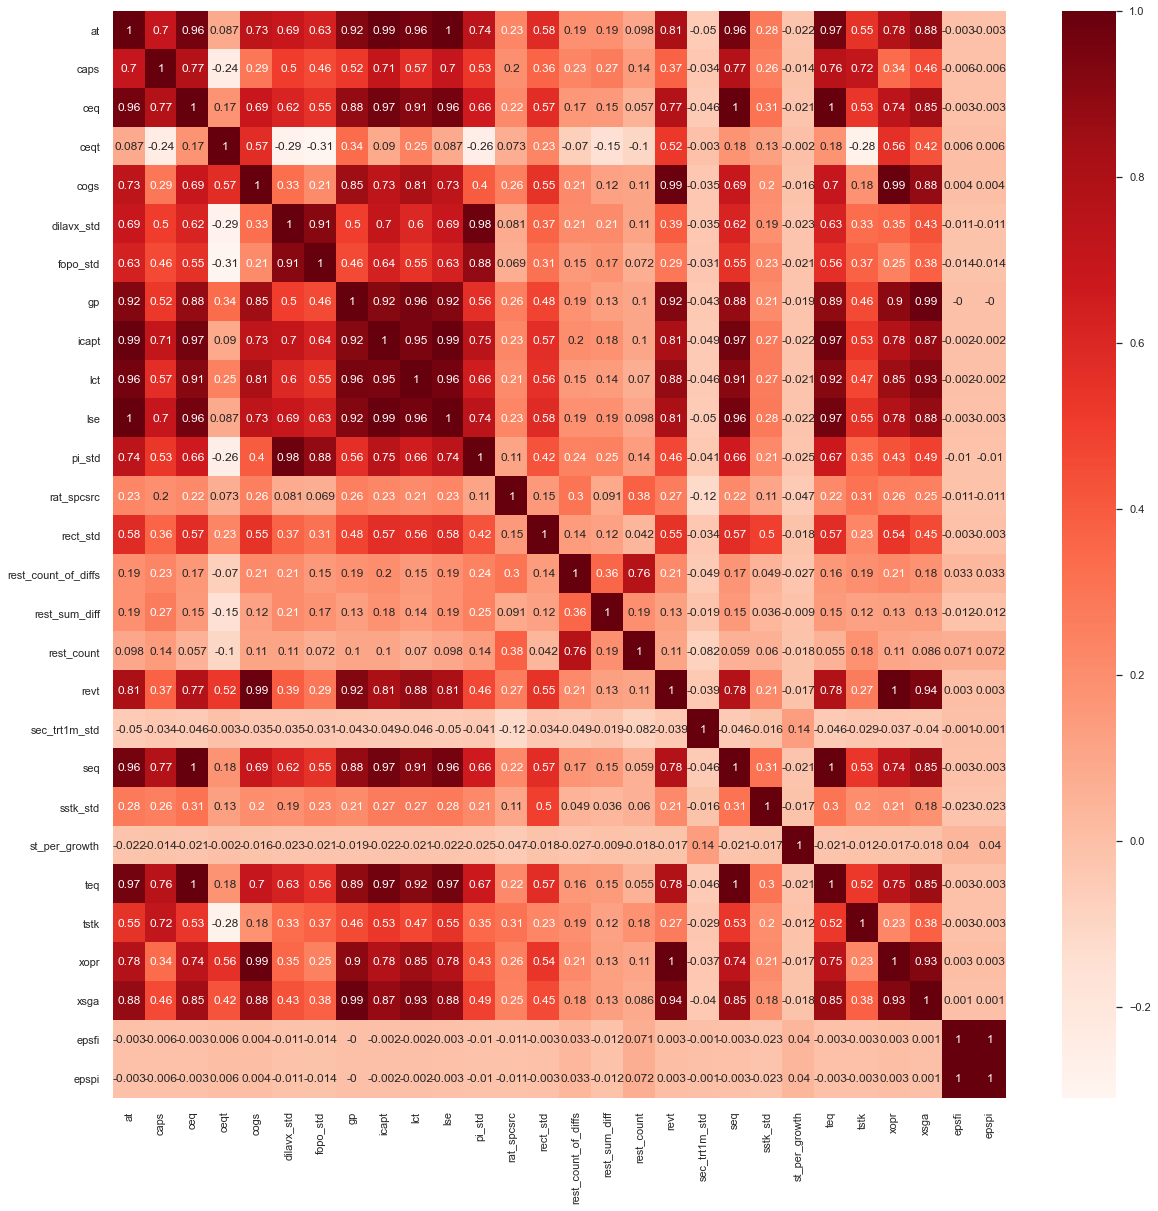

In [49]:
# Multiple Regressions -- Check for Correlations of Relevant Features Against Each
## Need to identify any collinear features
tempCLCheck = ls_Modeling.drop(columns=['lawsuit'])

plt.figure(figsize=(20,20))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap.png')


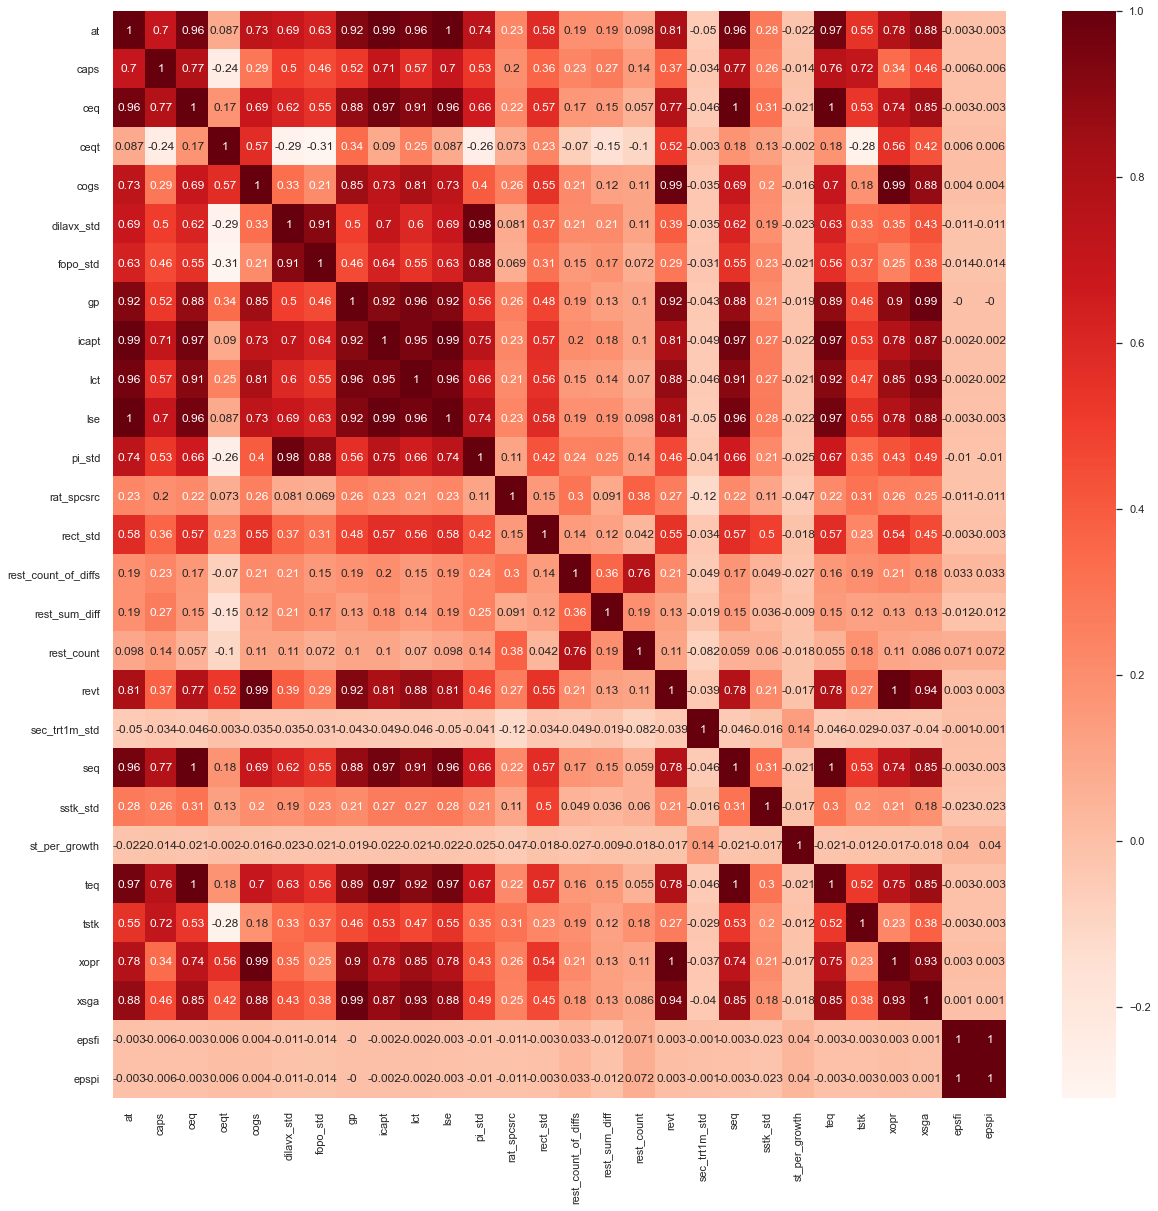

In [50]:
# Multiple Regression -- Replot Regression for Selected Variables
plt.figure(figsize=(20,20))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap.png')

## LawSuit Modeling -- Modeling

In [51]:
ls_Modeling

lawsuit       at      caps      ceq     ceqt     cogs  dilavx_std  \
gvkey                                                                       
1239          1 -0.24066 -0.107420 -0.13824  0.11416 -0.21536   -0.007951   
1266          0 -0.32871 -0.217020 -0.28943  0.01059 -0.24745   -0.316800   
1408          0  0.10983 -0.019370  0.30302 -0.05080 -0.20541    0.104840   
1429          0 -0.29217 -0.181038 -0.27058  0.04073 -0.19786   -0.321149   
1659          0 -0.23650 -0.178050 -0.23423  0.08879 -0.03254   -0.305800   
...         ...      ...       ...      ...      ...      ...         ...   
221545        0 -0.23758 -0.207420 -0.12958  0.26123 -0.15031   -0.121020   
222519        0 -0.17066 -0.219130 -0.18932  0.12787 -0.11840    0.121740   
241637        0  5.82959  3.916780  4.62649 -7.84982  0.41715   13.198870   
264393        0 -0.33830 -0.217980 -0.30452 -0.01358 -0.25023   -0.338700   
277487        0 -0.31938 -0.218880 -0.26947  0.04224 -0.24817   -0.320980   

        fopo_std       gp    icapt  ...  sec_trt1m_std      seq  sstk_std  \
gvkey                               ...                                     
1239    -0.14491 -0.19341 -0.20966  ...      -0.149950 -0.13920  0.233046   
1266    -0.31462 -0.29033 -0.31823  ...      -0.145000 -0.29129 -0.339700   
1408     0.00032 -0.11174  0.23814  ...      -0.149870  0.30339  0.230410   
1429    -0.31598 -0.24584 -0.29247  ...       0.070996 -0.26755 -0.339700   
1659    -0.29361 -0.24763 -0.25695  ...      -0.145310 -0.23589 -0.334990   
...          ...      ...      ...  ...            ...      ...       ...   
221545  -0.25924 -0.23527 -0.20974  ...      -0.149180 -0.13084 -0.338450   
222519  -0.02298 -0.13162 -0.15822  ...      -0.142180 -0.19081 -0.339700   
241637  12.14122  2.67914  6.52764  ...      -0.150770  4.64312  0.298960   
264393  -0.30930 -0.29351 -0.33249  ...      -0.112800 -0.30643 -0.339700   
277487  -0.28439 -0.29102 -0.30717  ...      -0.146100 -0.27126 -0.339700   

        st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  
gvkey                                                                          
1239           0.2500 -0.14483 -0.18762 -0.20887 -0.16900 -0.051470 -0.051130  
1266           0.3300 -0.29206 -0.18747 -0.25727 -0.27027 -0.047800 -0.048080  
1408           9.3600  0.28364  0.44655 -0.19359 -0.13639 -0.026060 -0.025610  
1429           4.1935 -0.26382 -0.18762 -0.20674 -0.22145 -0.001225  0.000962  
1659           1.0800 -0.23648 -0.18483 -0.07718 -0.23121  0.010280  0.010730  
...               ...      ...      ...      ...      ...       ...       ...  
221545         1.3300 -0.13630 -0.18762 -0.17123 -0.23100 -0.017860 -0.018150  
222519         5.3300 -0.17209 -0.18762 -0.11807 -0.10128 -0.054730 -0.055010  
241637         1.1100  4.96328 -0.12116  0.68968  1.58098  0.000620  0.001600  
264393         1.0000 -0.30672 -0.18762 -0.25968 -0.27112 -0.084240 -0.084520  
277487        -0.2500 -0.27267 -0.18762 -0.25755 -0.26855 -0.080880 -0.081160  

[348 rows x 29 columns]

In [52]:
# Split Out Boston Beer Company from Test/Train Sets -- To Be Used as it's on prediction set.
## 61581 is the gvkey for Boston Beer Company
ls_Modeling_SAM = ls_Modeling.loc[[61581]]
ls_Modeling = ls_Modeling.drop(index=(61581))

In [53]:
# Set or Reset Test/Train Split
# Params
df=ls_Modeling
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (277, 28)
x_test shape: (70, 28)


In [54]:
#TODO - check params with .get_params
# maybe add ration and check knn
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (277, 28)
y_train shape:  (277,)
x_test shape:  (70, 28)
y_test shape:  (70,)

y_train value counts: 0    243
1     34
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 28)
y_train shape:  (486,)
x_test shape:  (70, 28)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


## LawSuit Modeling -- First Model Evaluation

Models to Consider:
* Logistic Regression
* Bagging
* GradBoost
* Random Forests
* KNN
* LDA
* Classification Trees
* ADABoost

In [55]:
# Initial Quick Eval

# Set models
logReg_qe = LogisticRegression()
bag_qe =BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)
gb_qe = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
rf_qe = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32,n_jobs=-1)
knn_qe = KNeighborsClassifier(n_neighbors=2)
ada_qe = AdaBoostClassifier(n_estimators=100, random_state=0)
lda_qe =LinearDiscriminantAnalysis()
classTree_qe = tree.DecisionTreeClassifier()
gnb_qe = GaussianNB()

# Models List
models = [logReg_qe,bag_qe,gb_qe,rf_qe,knn_qe,ada_qe,lda_qe,classTree_qe,gnb_qe]

## Call Function
qe_summaryDF = quickModelComparison(models,x_train, x_test,
                                    y_train, y_test, qe_summaryDF ) # model list, X sets, y sets, summary df

print("quick evaluation report with vanilla test/train split:")
qe_summaryDF

quick evaluation report with vanilla test/train split:


Model  Accuracy  Precision  Recall      F1  \
0          LogisticRegression    0.6143     0.2000  0.4167  0.2703   
1           BaggingClassifier    0.7143     0.2143  0.2500  0.2308   
2  GradientBoostingClassifier    0.7000     0.2000  0.2500  0.2222   
3      RandomForestClassifier    0.7571     0.3077  0.3333  0.3200   
4        KNeighborsClassifier    0.6429     0.0667  0.0833  0.0741   
5          AdaBoostClassifier    0.6857     0.2500  0.4167  0.3125   
6  LinearDiscriminantAnalysis    0.6857     0.2222  0.3333  0.2667   
7      DecisionTreeClassifier    0.7000     0.2353  0.3333  0.2759   
8                  GaussianNB    0.3571     0.1765  0.7500  0.2857   

                    CM  
0   [[38, 20], [7, 5]]  
1   [[47, 11], [9, 3]]  
2   [[46, 12], [9, 3]]  
3    [[49, 9], [8, 4]]  
4  [[44, 14], [11, 1]]  
5   [[43, 15], [7, 5]]  
6   [[44, 14], [8, 4]]  
7   [[45, 13], [8, 4]]  
8   [[16, 42], [3, 9]]

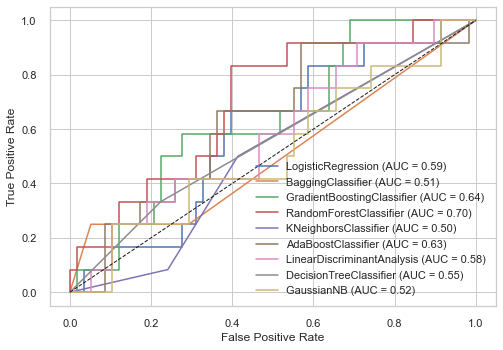

In [56]:
# Quick Eval ROC
# Compare ROC's/AUC's
# Plot First Model:
disp = plot_roc_curve(logReg_qe,x_test,y_test)
# To Add More Models, copy line below and replace model name:
plot_roc_curve(bag_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gb_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(rf_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(knn_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(ada_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(lda_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(classTree_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gnb_qe,x_test,y_test, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')
plt.savefig(plotLoc +'ROC-Compare.png')

## LawSuit Modeling -- Second Model Evaluation
TODO: Tune Models

From the first evaluation, any models that did not make any predictions for the positive response were
eliminted.

In this section, the models were tuned to try and improve the results.  Additionally, a voting classifier
was added that considers all the models.

Remaining Models:
* Logistic Regression - *Poor overall performance*
* Random Forests - *Best Accuracy (w/ a negative class prediction)*
* ADA Boost Classifier
* LDA - *Best Precision*
* Classification Trees - *Decent Performance - easiest to interpret*
* GaussianNB - *Wildcard: kept for different results, could be useful to voting classifer*


Eliminated Modes:
* GradBoost - *Poor overall performance - lowest recall/f1*
* Bagging - *Poor overall performance*
* KNN - *Poor overall performance*


### Lawsuit -- Second Eval -- Logistic Regressor

In [57]:
# Log Reg -- Create Regression Object. Fit Data, Make predictions
lr = LogisticRegression() # Create Regression object

lr.fit(x_train, y_train) ## Fit Data
y_pred_lr = lr.predict(x_test)

In [58]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

start plot


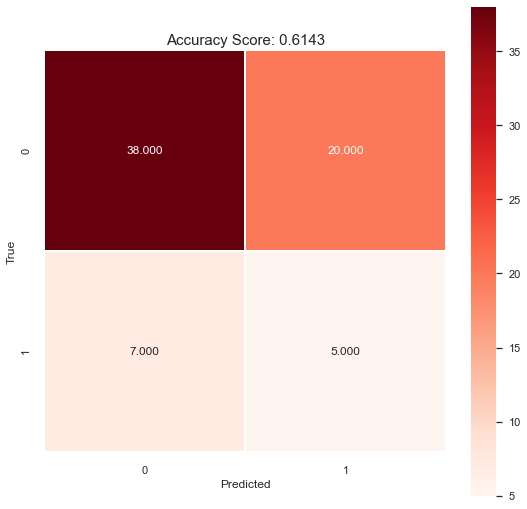

In [59]:
print("start plot")
cm, score = createConfMatrix(lr,y_test, y_pred_lr, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'LR_CM_Lawsuit.png')

In [60]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Logistic Regression -- Second Eval - Untunned"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_lr, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]

Start LR ROC Plot


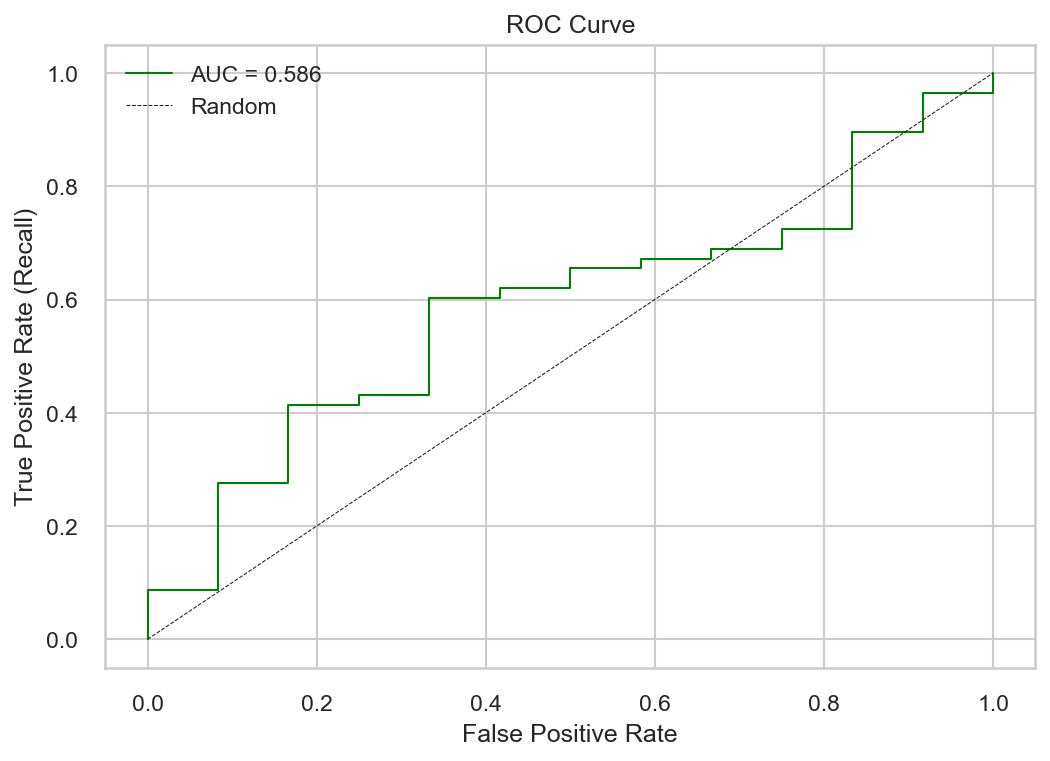

<Figure size 576x396 with 0 Axes>

In [61]:
# ROC Curve/ AUC Score
print("Start LR ROC Plot")

## Call Function
ROC_Curve_Plot(lr,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC_Lawsuit.png')


### Lawsuit -- Second Eval -- Random Forest Classifier

In [62]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32, min_samples_split=2, max_depth=3,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")


starting RF
done RF


start plot


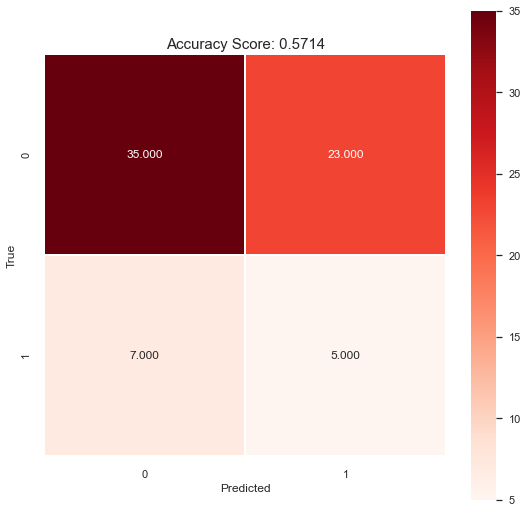

In [63]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_Lawsuit.png')

In [64]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest -- Second Eval - Tune=Recall"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]

Start RF ROC Plot


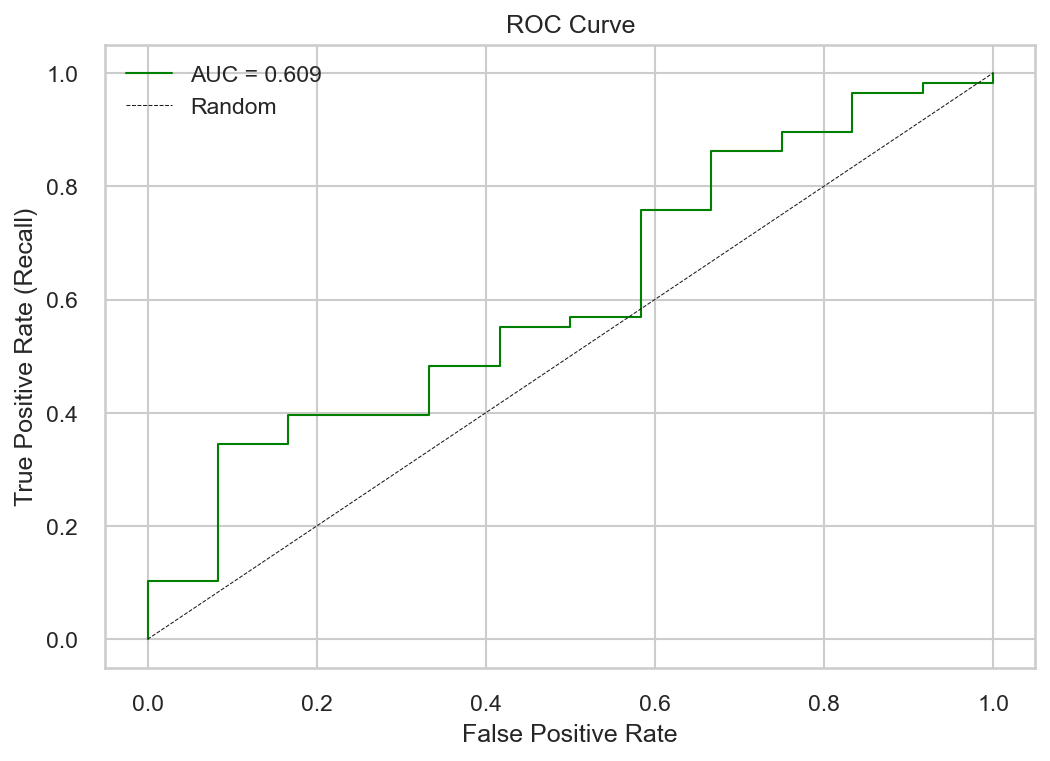

<Figure size 576x396 with 0 Axes>

In [65]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC_Lawsuit.png')

Start RF


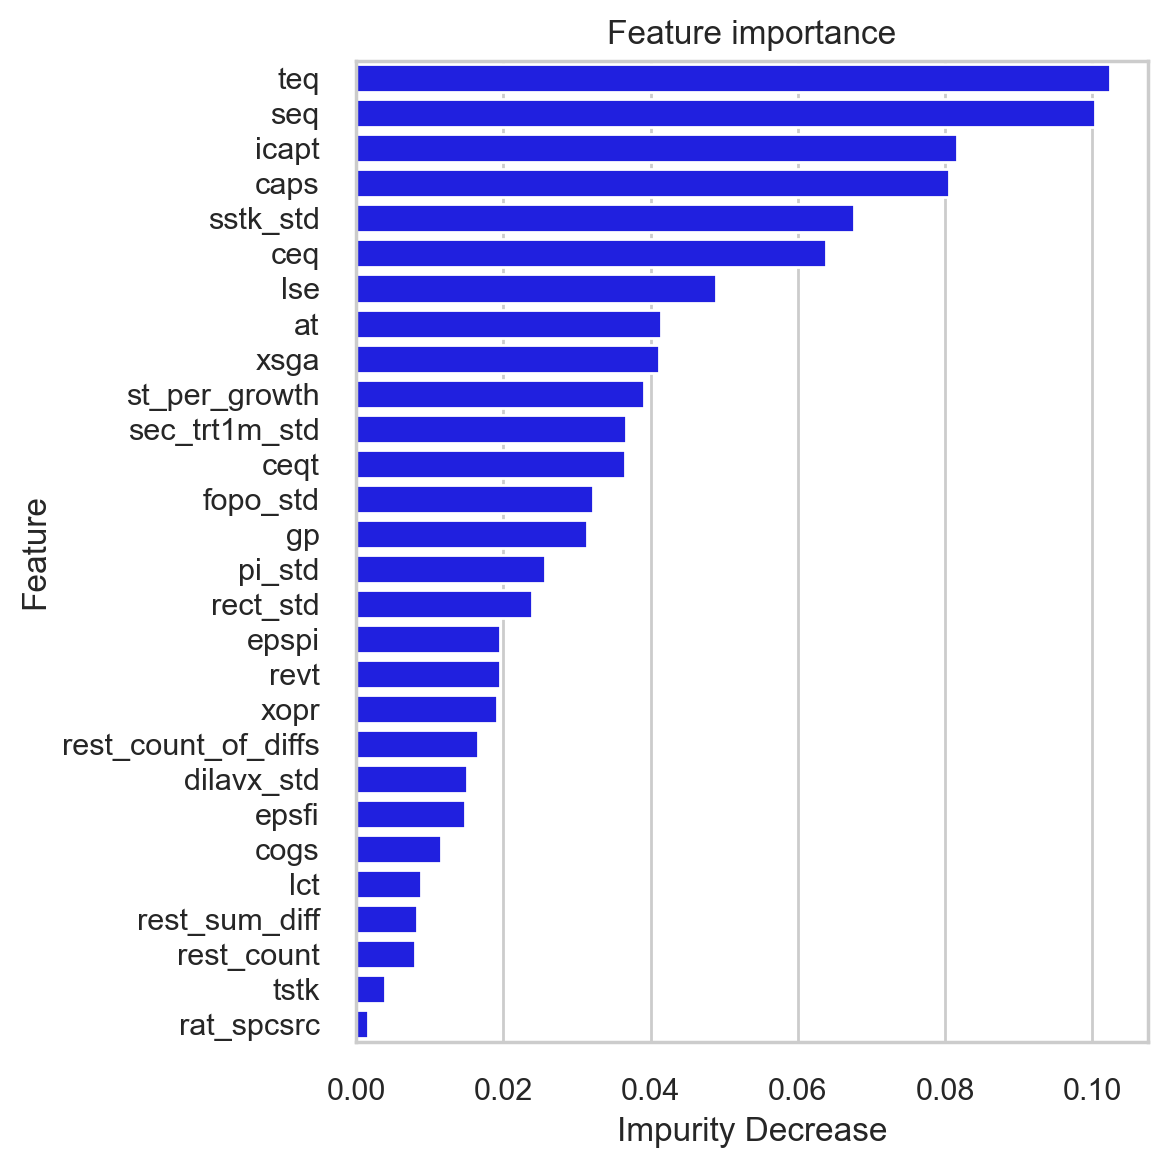

In [66]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance.png')

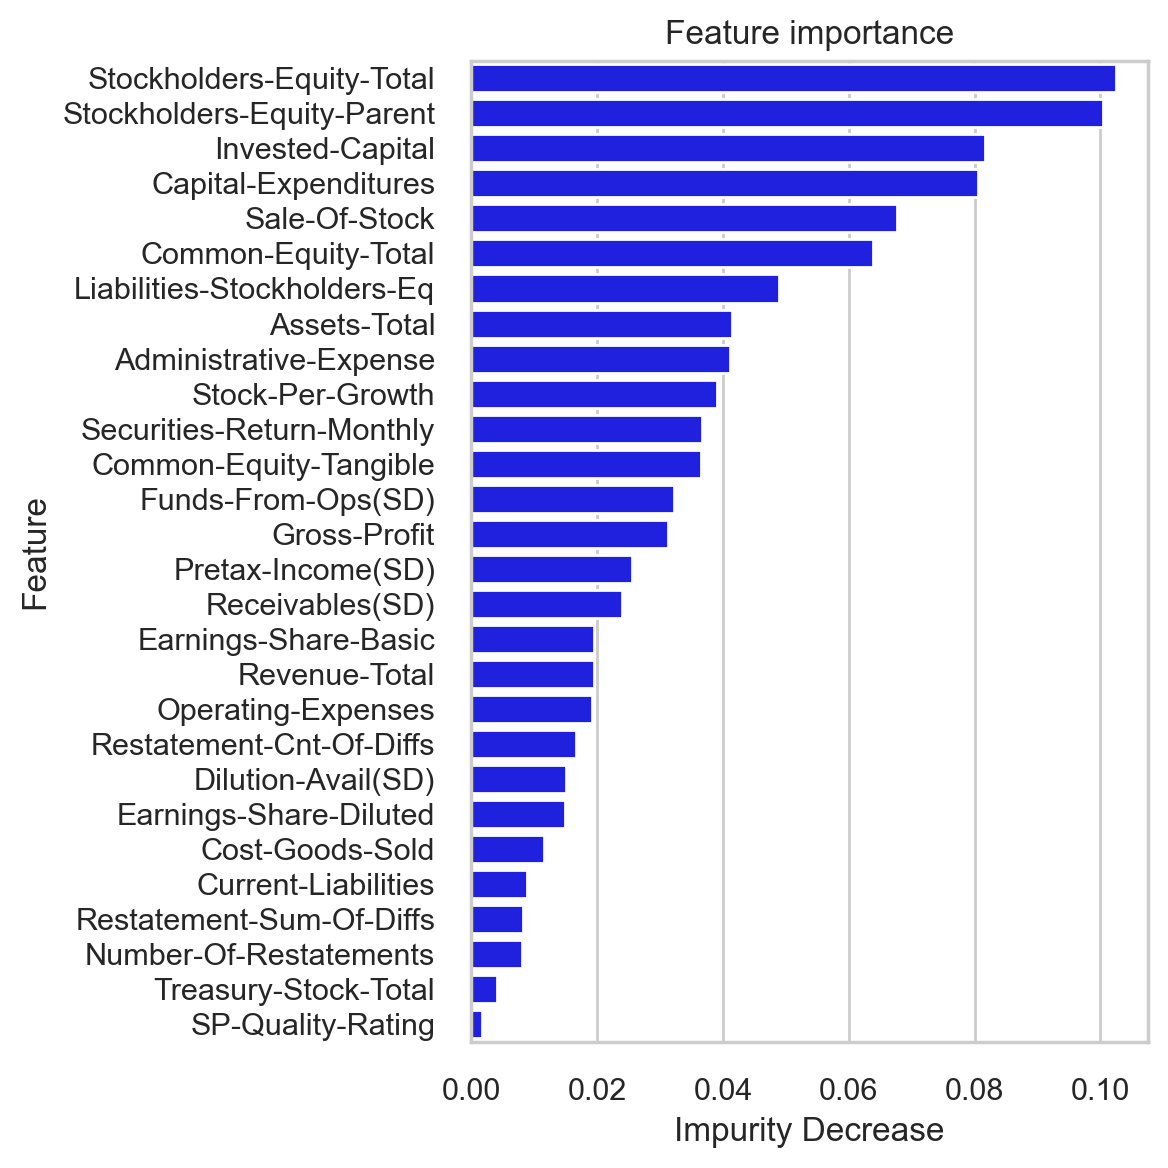

In [67]:
# Create Human Readable Feature Names For Feature Importance Plot
featureListDF = x_train
featureListDF = featureListDF.rename(columns={'at':'Assets-Total',
                                              'caps':'Capital-Expenditures',
                                              'ceq':'Common-Equity-Total',
                                              'ceqt':'Common-Equity-Tangible',
                                              'cogs':'Cost-Goods-Sold',
                                              'dilavx_std':'Dilution-Avail(SD)',
                                              'fopo_std':'Funds-From-Ops(SD)',
                                              'gp':'Gross-Profit',
                                              'icapt':'Invested-Capital',
                                              'lct':'Current-Liabilities',
                                              'lse':'Liabilities-Stockholders-Eq',
                                              'pi_std':'Pretax-Income(SD)',
                                              'rect_std':'Receivables(SD)',
                                              'rest_count_of_diffs':'Restatement-Cnt-Of-Diffs',
                                              'rest_sum_diff':'Restatement-Sum-Of-Diffs',
                                              'rest_count':'Number-Of-Restatements',
                                              'revt':'Revenue-Total',
                                              'sec_trt1m_std':'Securities-Return-Monthly',
                                              'seq':'Stockholders-Equity-Parent',
                                              'sstk_std':'Sale-Of-Stock',
                                              'st_per_growth':'Stock-Per-Growth',
                                              'teq':'Stockholders-Equity-Total',
                                              'tstk':'Treasury-Stock-Total',
                                              'xopr':'Operating-Expenses',
                                              'xsga':'Administrative-Expense',
                                              'epsfi':'Earnings-Share-Diluted',
                                              'epspi':'Earnings-Share-Basic',
                                              'rat_spcsrc':'SP-Quality-Rating'
                                              })

featureList = featureListDF.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance_For-Report.png')

### Lawsuit -- Second Eval -- ADA Boost Classifier

In [68]:
print("starting ADA")
# Random Forest
## Set and Fit Model
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.001, random_state=0)

ada.fit(x_train,y_train)

## Make Predictions
y_pred_ada = ada.predict(x_test)
print("done ADA2")


starting ADA
done ADA2


start plot


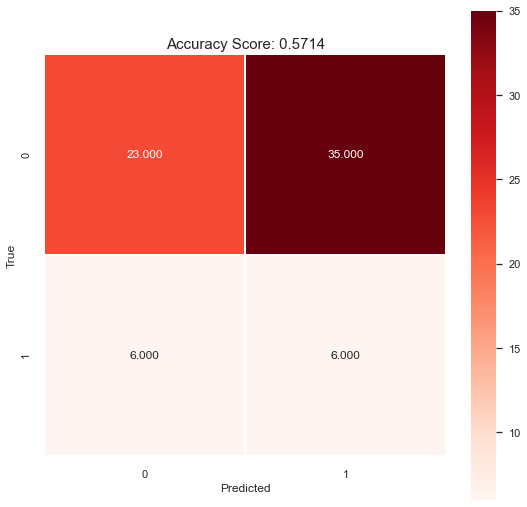

In [69]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_ada, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_Lawsuit.png')

In [70]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "ADA Boosting  -- Second Eval - Untuned"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_ada, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   
4         ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463  0.5000   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]  
4  0.2264  [[23, 35], [6, 6]]

Start ADA ROC Plot


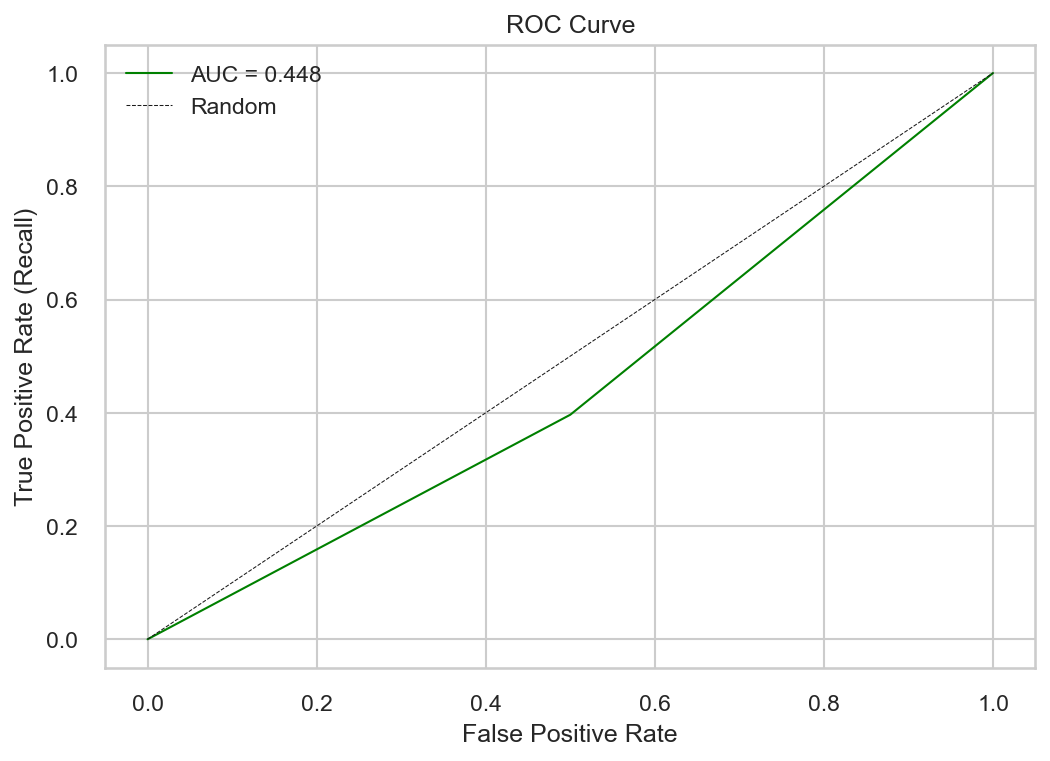

<Figure size 576x396 with 0 Axes>

In [71]:
# ROC Curve/ AUC Score
print("Start ADA ROC Plot")

## Call Function
ROC_Curve_Plot(ada,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'ADA_ROC_Lawsuit.png')

### Lawsuit -- Second Eval -- LDA

In [72]:
# LDA -- Create Regression Object. Fit Data, Make predictions
lda = LinearDiscriminantAnalysis(n_components=1,solver='lsqr')# Update Regression object
lda.fit(x_train, y_train) ## Fit Data
y_pred_lda = lda.predict(x_test)

In [73]:
lda.get_params()

{'n_components': 1,
 'priors': None,
 'shrinkage': None,
 'solver': 'lsqr',
 'store_covariance': False,
 'tol': 0.0001}

start plot


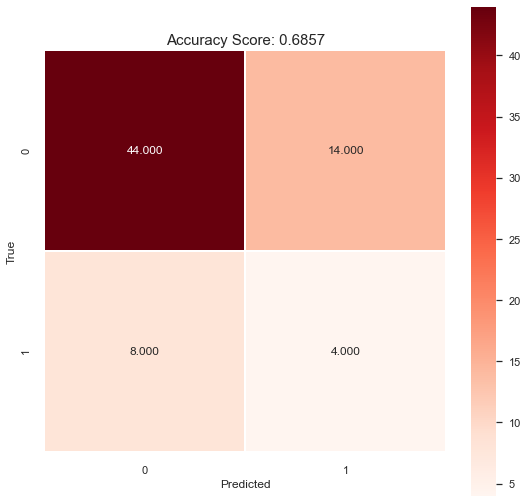

In [74]:
print("start plot")
cm, score = createConfMatrix(lda,y_test, y_pred_lda, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'LDA_CM_Lawsuit.png')

In [75]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "LDA -- Second Eval - Tuning=Recall"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_lda, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   
4         ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463  0.5000   
5             LDA -- Second Eval - Tuning=Recall    0.6857     0.2222  0.3333   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]  
4  0.2264  [[23, 35], [6, 6]]  
5  0.2667  [[44, 14], [8, 4]]

Start LDA ROC Plot


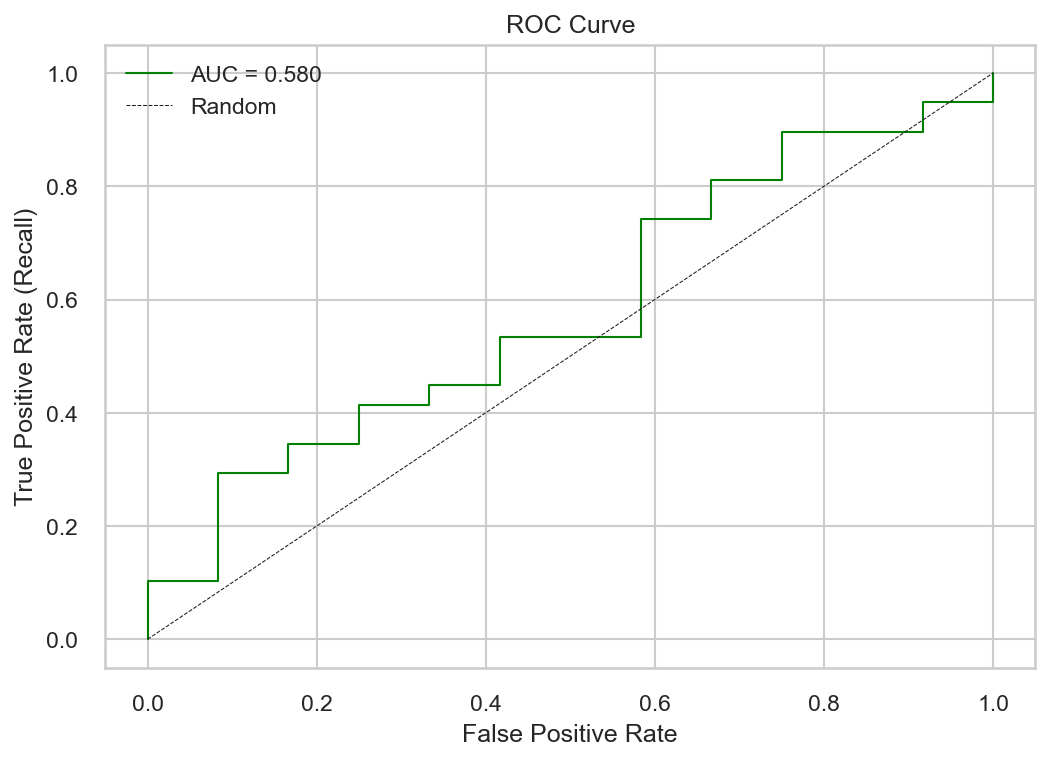

<Figure size 576x396 with 0 Axes>

In [76]:
# ROC Curve/ AUC Score
print("Start LDA ROC Plot")

## Call Function
ROC_Curve_Plot(lda,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'LDA_ROC_Lawsuit.png')

### Lawsuit -- Second Eval --Classification Tree


In [77]:
# DefaultTree -- Set and Train Model
defaultTree = tree.DecisionTreeClassifier()
defaultTree.fit(x_train,y_train).get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [78]:
# DefaultTree--  Get Summary Stats
df = defaultTree

default_training_score = round(recall_score(df.predict(x_train),y_train),4)
print(f"Training Score:", default_training_score)

default_test_score = round(recall_score(df.predict(x_test),y_test),4)
print(f"Test Score:", default_test_score)

depth = df.get_depth()
print(f"Depth:", depth)

leaves = df.get_n_leaves()
print(f"Terminal Nodes (Leaves):", leaves)

Training Score: 1.0
Test Score: 0.2105
Depth: 17
Terminal Nodes (Leaves): 45


In [79]:
# Best Tree -- Run CV

# Initialize rows and dataframe to store Results
row = []
cv_treeResults = pd.DataFrame(columns = ["depth","scores"])

print ("running CV...")
for x in range (1,30):
    depth = x
    cv_testTree = tree.DecisionTreeClassifier(max_depth=depth)
    # Perform 10-fold cross validation
    scores = cross_val_score(estimator=cv_testTree, X=x_train, y=y_train, cv=10, n_jobs=4)
    row = [depth,scores.mean()]
    df_length = len(cv_treeResults)
    cv_treeResults.loc[df_length] = row
print("best tree:")
print(cv_treeResults[cv_treeResults.scores == cv_treeResults.scores.max()])


running CV...
best tree:
    depth    scores
23   24.0  0.853614


Text(0.5, 0, 'Depth')

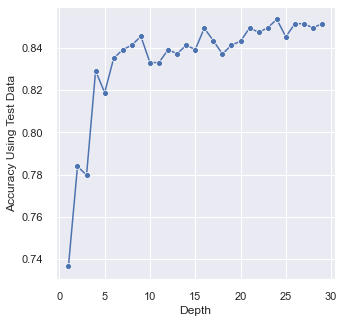

In [80]:
# Best Tree -- Plot CV

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(5,5)})
fig, ax = plt.subplots()
sns.lineplot(
    data=cv_treeResults,
    x="depth", y="scores",
    marker="o", dashes=False)
ax.set_ylabel("Accuracy Using Test Data")
ax.set_xlabel("Depth")

#plt.savefig('Figures/Best-Tree-Scores.png')

In [81]:
# Best Tree -- Parsimony Principle
## Take the best CV tree and look slightly smaller/larger to find the right balance of accuracy and
## Interprebility

bestTreeDepth = 4
bestTreeRange = 3
minTreeDepth = bestTreeDepth - bestTreeRange
maxTreeDepth = bestTreeDepth + bestTreeRange

row = []
pars_treeResults = pd.DataFrame(columns = ["depth","trainScore","testScore","leaves"])

for x in range (minTreeDepth,maxTreeDepth):
    depth = x
    parsTree = tree.DecisionTreeClassifier(max_depth=depth)
    parsTree.fit(x_train,y_train)
    parsTree_TrainingScore = round(recall_score(parsTree.predict(x_train),y_train),4)
    parsTree_TestScore = round(recall_score(parsTree.predict(x_test),y_test),4)
    leaves = parsTree.get_n_leaves()
    row = [depth, parsTree_TrainingScore, parsTree_TestScore, leaves ]
    df_length = len(pars_treeResults)
    pars_treeResults.loc[df_length] = row
pars_treeResults

depth  trainScore  testScore  leaves
0    1.0      0.6746     0.1463     2.0
1    2.0      0.7500     0.1290     4.0
2    3.0      0.8150     0.1429     7.0
3    4.0      0.8406     0.1500    12.0
4    5.0      0.8731     0.1500    17.0
5    6.0      0.8881     0.1667    21.0

In [82]:
# Best Tree -- Set and Train Model On Best Model considering principle of parsimony
cv_bestTree = tree.DecisionTreeClassifier(min_samples_split=2,max_depth=4)
cv_bestTree.fit(x_train,y_train)
y_pred_cTree = cv_bestTree.predict(x_test)
print("Done")

Done


In [83]:
cv_bestTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [84]:
# Best Tree --  Get Summary Stats
df = cv_bestTree

bestTree_trainingScore = round(recall_score(df.predict(x_train),y_train),4)
print(f"Training Score:", bestTree_trainingScore)

bestTree_TestScore = round(recall_score(df.predict(x_test),y_test),4)
print(f"Best Tree Test Score:", bestTree_TestScore)

depth = df.get_depth()
print(f"Depth:", depth)

leaves = df.get_n_leaves()
print(f"Terminal Nodes (Leaves):", leaves)

Training Score: 0.8406
Best Tree Test Score: 0.15
Depth: 4
Terminal Nodes (Leaves): 12


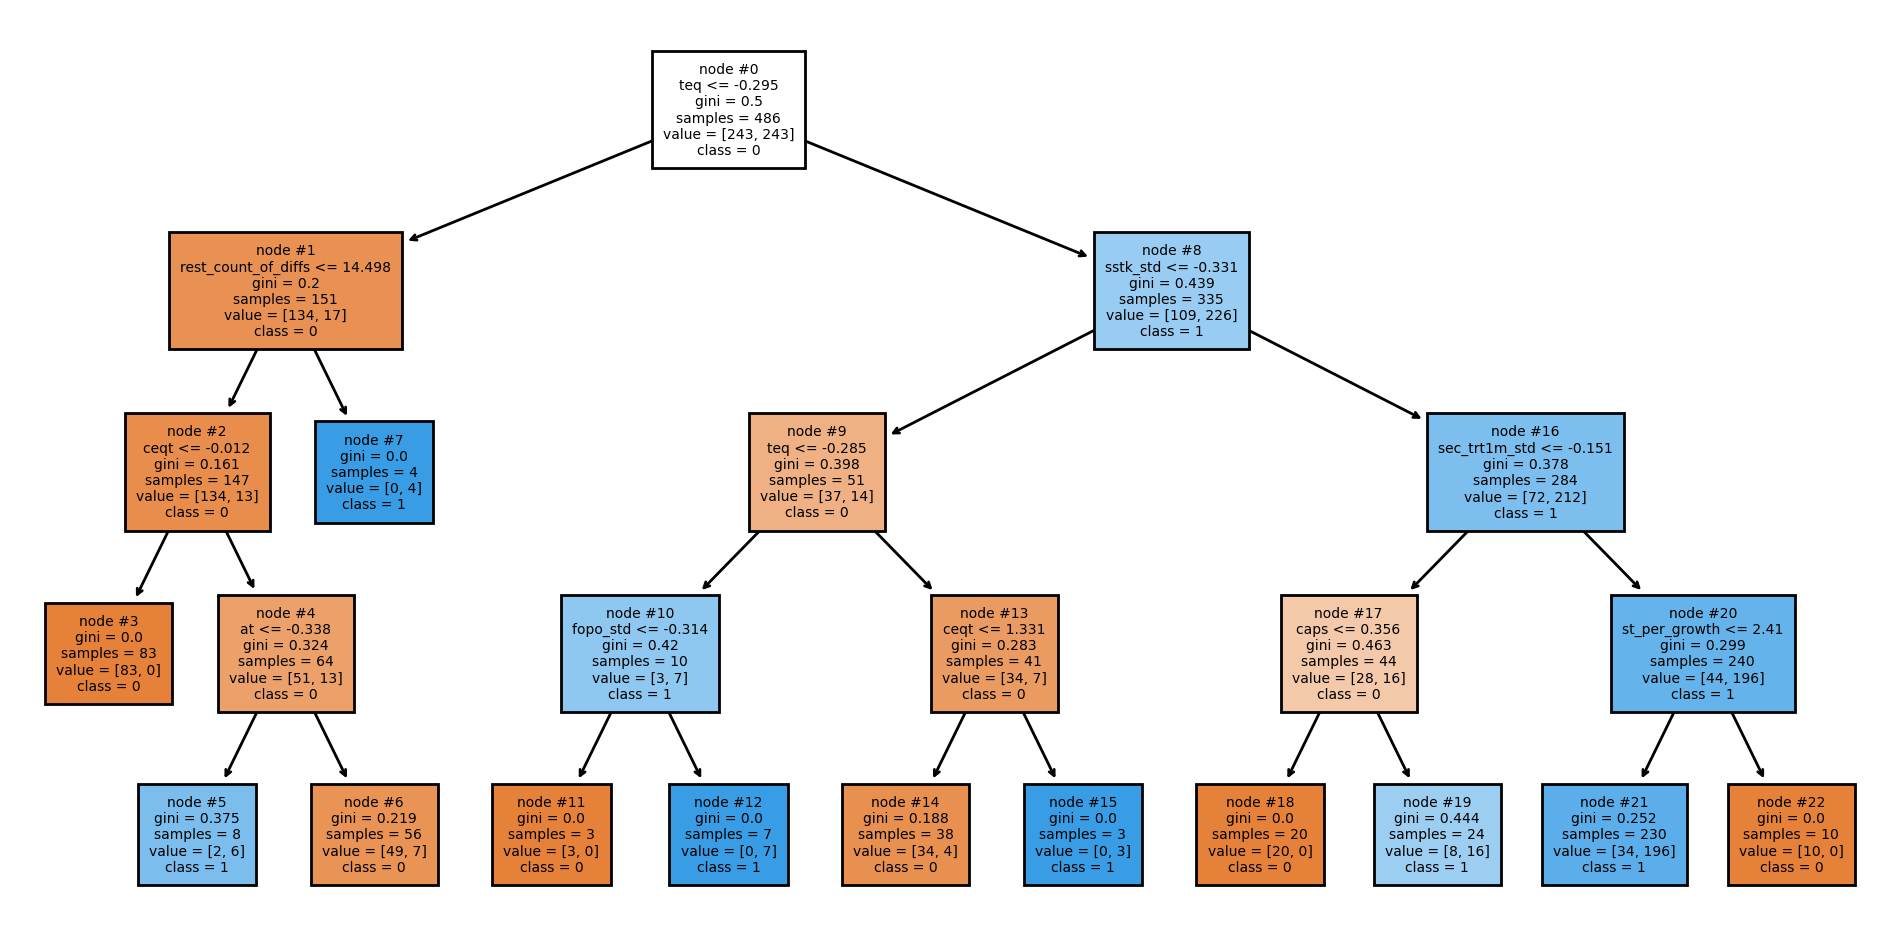

In [85]:
# Best Tree-- Plot Tree
sns.reset_orig()
ResponseVar = 'lawsuit'
PredictorVar = x_train.columns.values.tolist()
cn = ['0','1']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,6), dpi=200)

tree.plot_tree(df,
               feature_names = PredictorVar,
               class_names=cn,
               fontsize=5,
               node_ids=True,
               filled = True);

#plt.savefig('Figures/Best-Tree.png')

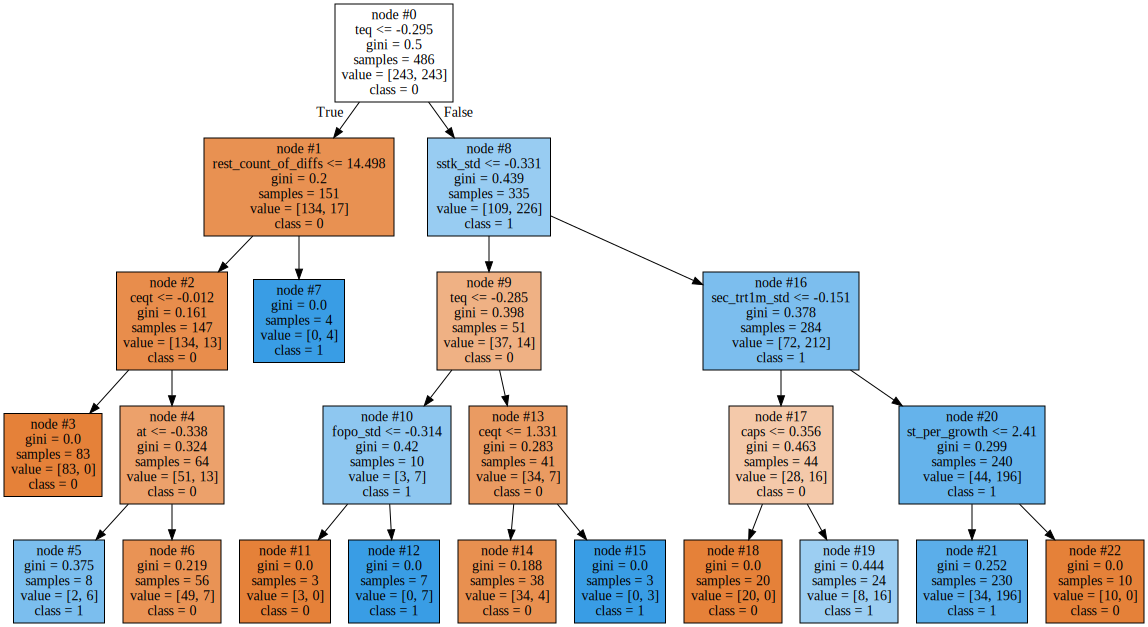

In [86]:
#Plot Best Tree
dot_data = tree.export_graphviz(cv_bestTree, out_file=None,
                                feature_names=PredictorVar,
                                class_names=cn,
                                node_ids =True,
                                #rotate = True,
                                filled=True)


# Draw graph
BM_BestTree = graphviz.Source(dot_data, format="png")
#BM_BestTree.render('Figures/BM_BestTree',view=True)
BM_BestTree

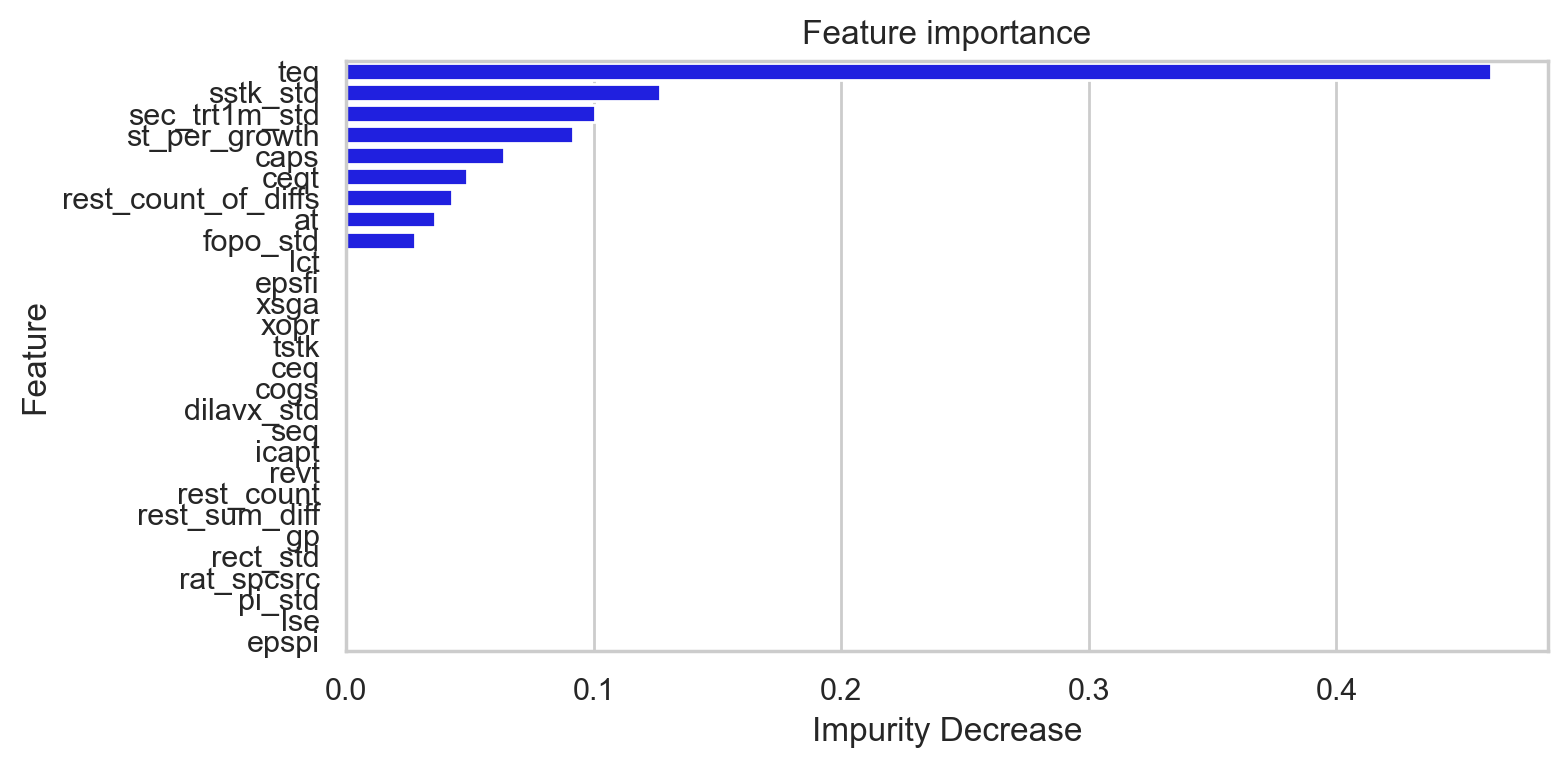

In [87]:
# Best Tree-- Plot Most Important Features
importances = cv_bestTree.feature_importances_

#Convert Array to DF
feature_importances = pd.Series(importances, index=PredictorVar)
feature_importances = feature_importances.to_frame().reset_index()
feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
#std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (8,4), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")
fig.tight_layout()

#plt.savefig('Figures/Best-Tree-Feauture-Importance.png')

start cTree plot


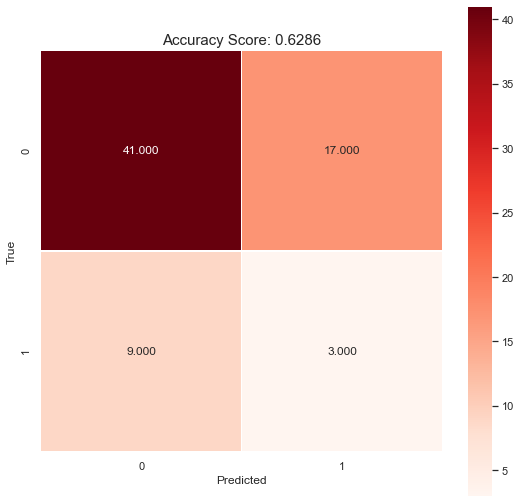

In [88]:
print("start cTree plot")
cm, score = createConfMatrix(cv_bestTree,y_test, y_pred_cTree, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'cTree_CM_Lawsuit.png')

In [89]:
# CTree -- Precision/Recall Scores

## Set Params
model_name = "Classification Tree -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_cTree, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   
4         ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463  0.5000   
5             LDA -- Second Eval - Tuning=Recall    0.6857     0.2222  0.3333   
6             Classification Tree -- Second Eval    0.6286     0.1500  0.2500   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]  
4  0.2264  [[23, 35], [6, 6]]  
5  0.2667  [[44, 14], [8, 4]]  
6  0.1875  [[41, 17], [9, 3]]

Start CTree ROC Plot


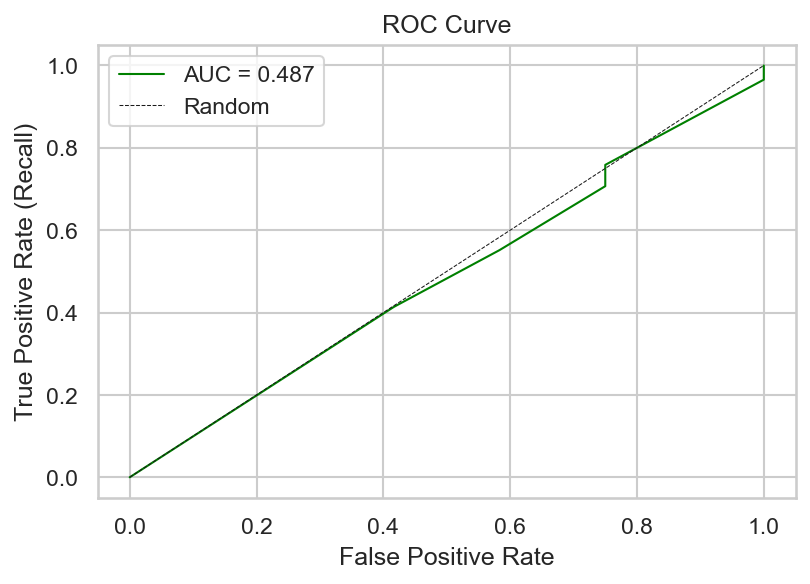

<Figure size 432x288 with 0 Axes>

In [90]:
# ROC Curve/ AUC Score
print("Start CTree ROC Plot")

## Call Function
ROC_Curve_Plot(cv_bestTree,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'cTree_ROC_Lawsuit.png')

### Lawsuit -- Second Eval -- GaussianNB

Note to self: Including this model in case I use Voting Classifier as it may balance out the tendency for
most models to predict 0.

In [91]:
print("starting GaussianNB")
# GaussianNB
## Set and Fit Model
gnb = GaussianNB()
gnb.fit(x_train,y_train)

## Make Predictions
y_pred_gnb = gnb.predict(x_test)
print("done predict gnb")

starting GaussianNB
done predict gnb


start gnb plot


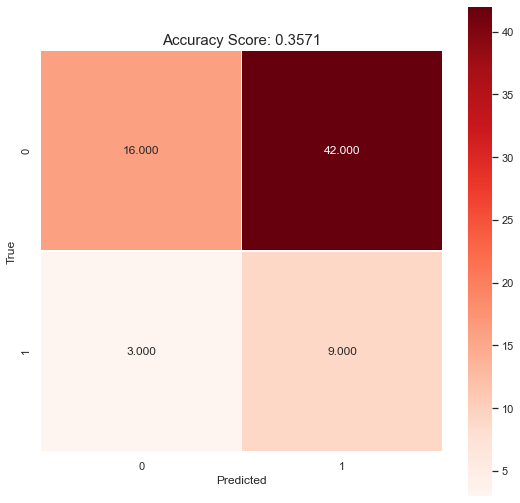

In [92]:
print("start gnb plot")
cm, score = createConfMatrix(gnb,y_test, y_pred_gnb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GNB_CM_Lawsuit.png')

In [93]:
# GNB -- Precision/Recall Scores

## Set Params
model_name = "GaussianNB"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gnb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   
4         ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463  0.5000   
5             LDA -- Second Eval - Tuning=Recall    0.6857     0.2222  0.3333   
6             Classification Tree -- Second Eval    0.6286     0.1500  0.2500   
7                                     GaussianNB    0.3571     0.1765  0.7500   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]  
4  0.2264  [[23, 35], [6, 6]]  
5  0.2667  [[44, 14], [8, 4]]  
6  0.1875  [[41, 17], [9, 3]]  
7  0.2857  [[16, 42], [3, 9]]

Start GNB ROC Plot


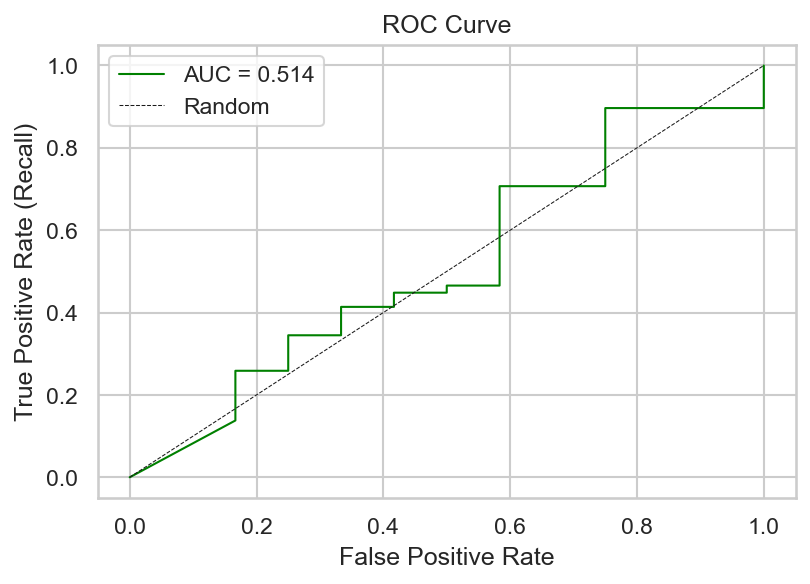

<Figure size 432x288 with 0 Axes>

In [94]:
# ROC Curve/ AUC Score
print("Start GNB ROC Plot")

## Call Function
ROC_Curve_Plot(gnb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GNB_ROC_Lawsuit.png')

## Compare all Models

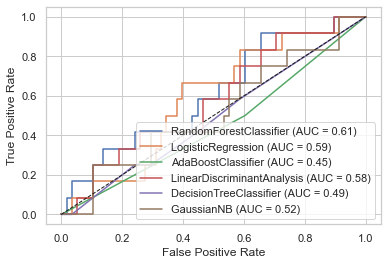

In [95]:
# Compare ROC's/AUC's
# Plot First Model:
disp = plot_roc_curve(rf,x_test,y_test)
# To Add More Models, copy line below and replace model name:
plot_roc_curve(lr,x_test,y_test, ax=disp.ax_)
plot_roc_curve(ada,x_test,y_test, ax=disp.ax_)
plot_roc_curve(lda,x_test,y_test, ax=disp.ax_)
plot_roc_curve(cv_bestTree,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gnb,x_test,y_test, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')
plt.savefig(plotLoc +'ROC-Compare_Second-Eval.png')

## LawSuit Modeling -- Third Model Evaluation

From the second evaluation, I picked the most promising models: Random Forest & Logistic Regression

In this section, the feature sets were tailored to the specific models, which were then tuned for a final comparison.

Remaining Models:
* Logistic Regression - *Poor overall performance*
* Random Forests - *Best Accuracy (w/ a negative class prediction)*
* *NEW:* Voting Classifier (May use ADA Boosting and/or GaussianNB)

Eliminated Modes:
* GradBoost - *(Eliminated in round 1) -- Poor overall performance - lowest recall/f1*
* Bagging - *(Eliminated in round 1) --Poor overall performance*
* QDA - *(Eliminated in round 1) --Only predicted positive class*
* KNN - *(Eliminated in round 2) --TODO: add reason*
* LDA - *(Eliminated in round 2) --TODO: add reason*
* Classification Trees - *(Eliminated in round 2) --TODO: add reason*
* GaussianNB - *(Eliminated in round 2) --TODO: add reason*

In [96]:
plotLoc = plotLoc +'Plots/FinalEval/'
plotLoc

'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Plots/FinalEval/'

### Lawsuit -- Third Eval -- Logistic Regressor

https://medium.com/mlearning-ai/short-python-code-for-backward-elimination-with-detailed-explanation-52894a9a7880

In [97]:
# Create RF Specific Modeling Set -- Copy and Trim DF
LR_Final_ModelingDF = ls_Modeling.copy()

In [98]:
df = LR_Final_ModelingDF
respVar = 'lawsuit'
signLevel = 0.05

lr_signFeatDF, lr_nonsignFeatList = backwardElimination(df,respVar,signLevel)
print(f"non-signifant features:",lr_nonsignFeatList)
lr_signFeatDF

non-signifant features: ['at', 'lse', 'pi_std', 'rest_count_of_diffs', 'sstk_std', 'xsga']


feature    pvalue
0            caps  0.918697
1        rect_std  0.901755
2            xopr  0.877353
3           icapt  0.884596
4   st_per_growth  0.845561
5      rest_count  0.800868
6             ceq  0.746177
7      dilavx_std  0.777067
8        fopo_std  0.802151
9             lct  0.549320
10           ceqt  0.475957
11           tstk  0.578104
12             gp  0.456909
13           cogs  0.690213
14           revt  0.503774
15  sec_trt1m_std  0.437957
16     rat_spcsrc  0.366825
17            teq  0.268028
18  rest_sum_diff  0.165113
19          epspi  0.115206
20          epsfi  0.596638
21            seq  0.086559

In [99]:
# Clean Actions Report -- Drop gsubind (Only kept to inform Imputing)
cleanActionsDesc = "Drop features w/ low impDecrease from Round 2"
df_name = "LR_Final_ModelingDF"
colsToDrop = lr_nonsignFeatList

LR_Final_ModelingDF = LR_Final_ModelingDF.drop(columns=colsToDrop)
cleanActionsReport(LR_Final_ModelingDF,df_name,cleanActionsDesc,colsToDrop)

LR_Final_ModelingDF.sample(3)

lawsuit     caps      ceq     ceqt     cogs  dilavx_std  fopo_std  \
gvkey                                                                      
17494        0 -0.21726 -0.30394 -0.01257 -0.25055    -0.34369  -0.31580   
65105        1 -0.16603 -0.16781  0.20491  0.19614    -0.32824  -0.17202   
12756        1  0.64195  0.04629 -0.24947 -0.00550    -0.19087  -0.18924   

            gp    icapt      lct  ...  rest_count     revt  sec_trt1m_std  \
gvkey                             ...                                       
17494 -0.29371 -0.33212 -0.31944  ...         1.0 -0.27157       -0.13755   
65105 -0.14698 -0.24193 -0.13122  ...         2.0  0.09880       -0.14897   
12756  0.05551  0.14204  0.07138  ...         4.0  0.01453       -0.15090   

           seq  st_per_growth      teq     tstk     xopr    epsfi    epspi  
gvkey                                                                       
17494 -0.30586           0.18 -0.30616 -0.18762 -0.25989 -0.08686 -0.08715  
65105 -0.16921           0.57 -0.17388 -0.05262  0.13102 -0.04023 -0.03968  
12756  0.04569           1.24  0.03417  0.11015  0.00069 -0.03656 -0.03569  

[3 rows x 23 columns]

In [100]:
# Create LR Specific Modeling Set -- Set or Reset Test/Train Split
# Params
df=LR_Final_ModelingDF
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (277, 22)
x_test shape: (70, 22)


In [101]:
# Create RF Specific Modeling Set --Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (277, 22)
y_train shape:  (277,)
x_test shape:  (70, 22)
y_test shape:  (70,)

y_train value counts: 0    243
1     34
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 22)
y_train shape:  (486,)
x_test shape:  (70, 22)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


In [102]:
# Log Reg -- Create Regression Object. Fit Data, Make predictions
lr3 = LogisticRegression() # Create Regression object

lr3.fit(x_train, y_train) ## Fit Data
y_pred_lr3 = lr3.predict(x_test)

start plot


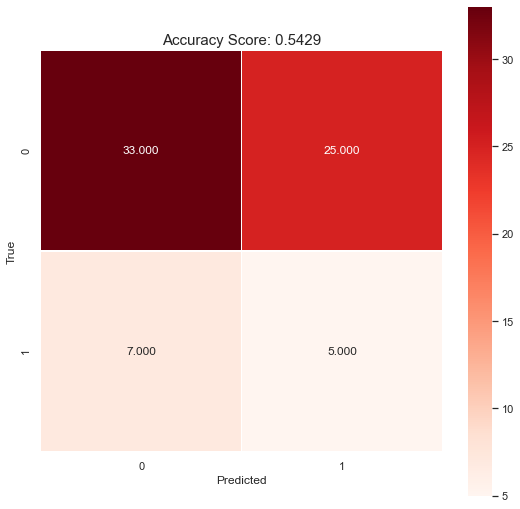

In [103]:
print("start plot")
cm, score = createConfMatrix(lr3,y_test, y_pred_lr3, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'LR_CM_Lawsuit.png')

In [104]:
# Logistic Regressor -- Precision/Recall Scores

## Set Params
model_name = "Logistic Regression -- Third Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_lr3, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  Recall  \
0    Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500  0.3636   
1    Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818  0.1818   
2  Logistic Regression -- Second Eval - Untunned    0.6143     0.2000  0.4167   
3     Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786  0.4167   
4         ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463  0.5000   
5             LDA -- Second Eval - Tuning=Recall    0.6857     0.2222  0.3333   
6             Classification Tree -- Second Eval    0.6286     0.1500  0.2500   
7                                     GaussianNB    0.3571     0.1765  0.7500   
8              Logistic Regression -- Third Eval    0.5429     0.1667  0.4167   

       F1                  CM  
0  0.2963  [[47, 12], [7, 4]]  
1  0.1818   [[50, 9], [9, 2]]  
2  0.2703  [[38, 20], [7, 5]]  
3  0.2500  [[35, 23], [7, 5]]  
4  0.2264  [[23, 35], [6, 6]]  
5  0.2667  [[44, 14], [8, 4]]  
6  0.1875  [[41, 17], [9, 3]]  
7  0.2857  [[16, 42], [3, 9]]  
8  0.2381  [[33, 25], [7, 5]]

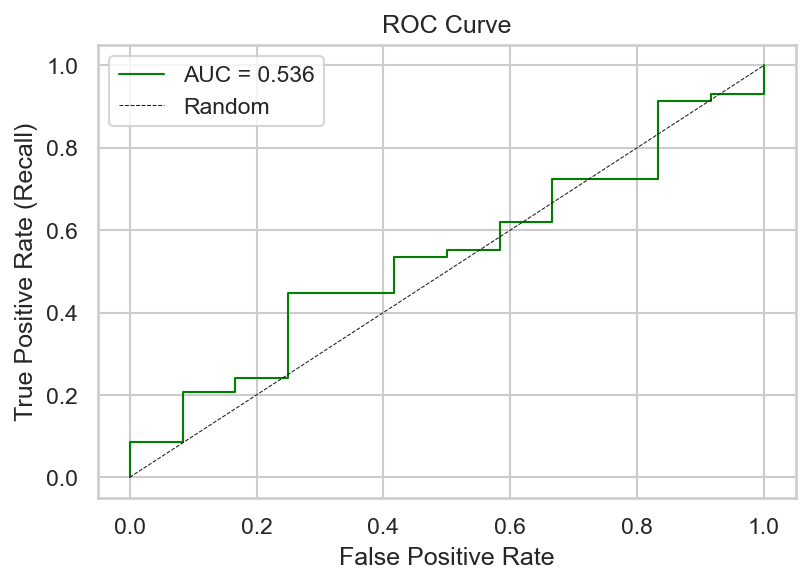

<Figure size 432x288 with 0 Axes>

In [105]:
# ROC Curve/ AUC Score
## Call Function
ROC_Curve_Plot(lr3,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'LR_ROC_Lawsuit.png')

### Lawsuit -- Final Eval -- Random Forest Classifier

In [154]:
# Create RF Specific Modeling Set -- Copy and Trim DF
RF_Final_ModelingDF = ls_Modeling.copy()

# Drop Columns w/ low impDecrease from second round (manually keyed to avoid any variation in re-runs)
colsToDrop = ['rat_spcsrc'] # Set under 0.01

# parking lot:'lse','epsfi','dilavx_std','lct','epspi','st_per_growth',,# Set over 0.01 and under 0.025
              # 'at', #Under 0.025 Only After Removing Set Above

# Clean Actions Report -- Drop gsubind (Only kept to inform Imputing)
cleanActionsDesc = "Drop features w/ low impDecrease from Round 2"
df_name = "RF_Final_ModelingDF"

RF_Final_ModelingDF = RF_Final_ModelingDF.drop(columns=colsToDrop)
cleanActionsReport(RF_Final_ModelingDF,df_name,cleanActionsDesc,colsToDrop)

RF_Final_ModelingDF.sample(3)

lawsuit       at      caps      ceq     ceqt     cogs  dilavx_std  \
gvkey                                                                       
134464        0  0.32896  0.309664  0.18050  0.74275  1.52476    0.610039   
182497        0 -0.33153 -0.217880 -0.29301  0.00489 -0.25056   -0.336120   
170535        0 -0.33840 -0.218590 -0.30429 -0.01313 -0.25078   -0.342210   

        fopo_std       gp    icapt  ...  sec_trt1m_std      seq  sstk_std  \
gvkey                               ...                                     
134464  -0.27612 -0.07893  0.15569  ...        0.06594  0.22060  -0.33970   
182497  -0.31181 -0.29388 -0.32488  ...       -0.15005 -0.29488  -0.33970   
170535  -0.31509 -0.29394 -0.33236  ...       -0.12356 -0.30621  -0.31689   

        st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  
gvkey                                                                          
134464          -0.01  0.22590 -0.18762  1.17287 -0.19227 -0.002094 -0.001422  
182497           0.01 -0.29554 -0.18762 -0.25985 -0.27070 -0.130870 -0.131150  
170535           1.80 -0.30650 -0.18762 -0.26017 -0.27134 -0.085080 -0.085360  

[3 rows x 28 columns]

In [155]:
# Create RF Specific Modeling Set -- Set or Reset Test/Train Split
# Params
df=RF_Final_ModelingDF
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (277, 27)
x_test shape: (70, 27)


In [156]:
# Create RF Specific Modeling Set --Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (277, 27)
y_train shape:  (277,)
x_test shape:  (70, 27)
y_test shape:  (70,)

y_train value counts: 0    243
1     34
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 27)
y_train shape:  (486,)
x_test shape:  (70, 27)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


In [157]:
print("starting RF")
# Random Forest
## Set and Fit Model

rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32, min_samples_split=2, max_depth=3,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [110]:
#Threshold Override -- Experimented, but didn't work
threshold = 0.55
predicted_proba = rf.predict_proba(x_test)
#y_pred_rf = (predicted_proba [:,1] >= threshold).astype('int')
#y_pred_rf

start plot


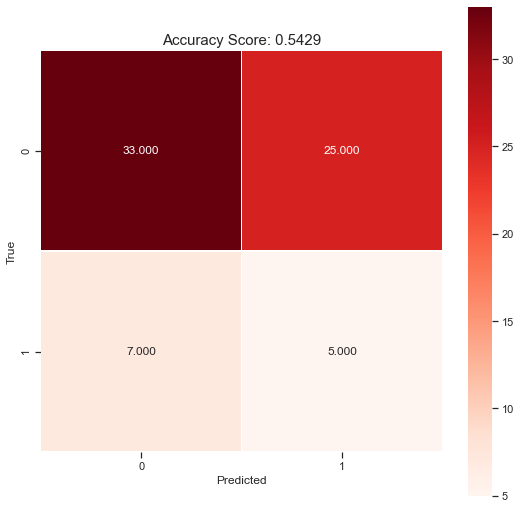

In [158]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_Final_Lawsuit.png')

In [112]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest -- Third Eval - w/oFeatures<0.1 -- Recall Tuning from Round 2"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  \
0        Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500   
1        Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818   
2      Logistic Regression -- Second Eval - Untunned    0.6143     0.2000   
3         Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786   
4             ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463   
5                 LDA -- Second Eval - Tuning=Recall    0.6857     0.2222   
6                 Classification Tree -- Second Eval    0.6286     0.1500   
7                                         GaussianNB    0.3571     0.1765   
8                  Logistic Regression -- Third Eval    0.5429     0.1667   
9  Random Forest -- Third Eval - w/oFeatures<0.1 ...    0.5429     0.1667   

   Recall      F1                  CM  
0  0.3636  0.2963  [[47, 12], [7, 4]]  
1  0.1818  0.1818   [[50, 9], [9, 2]]  
2  0.4167  0.2703  [[38, 20], [7, 5]]  
3  0.4167  0.2500  [[35, 23], [7, 5]]  
4  0.5000  0.2264  [[23, 35], [6, 6]]  
5  0.3333  0.2667  [[44, 14], [8, 4]]  
6  0.2500  0.1875  [[41, 17], [9, 3]]  
7  0.7500  0.2857  [[16, 42], [3, 9]]  
8  0.4167  0.2381  [[33, 25], [7, 5]]  
9  0.4167  0.2381  [[33, 25], [7, 5]]

Start RF ROC Plot


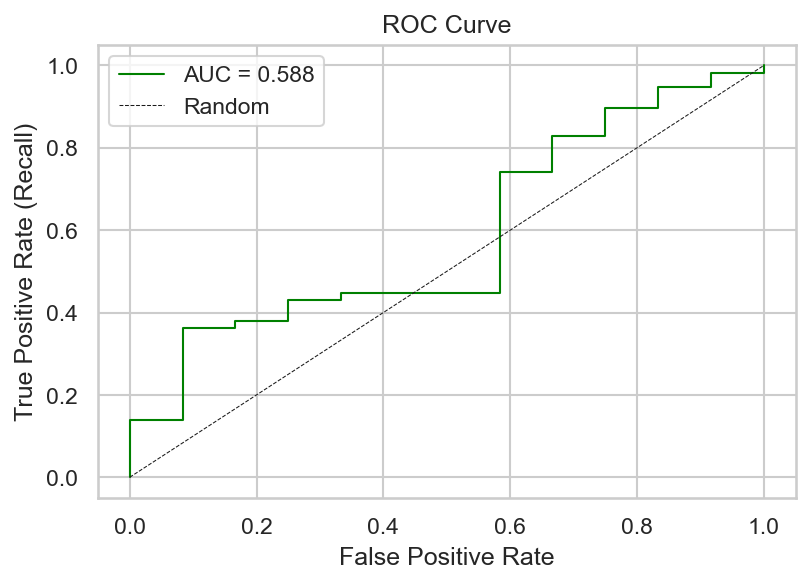

<Figure size 432x288 with 0 Axes>

In [113]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC_Final_Lawsuit.png')

Start RF


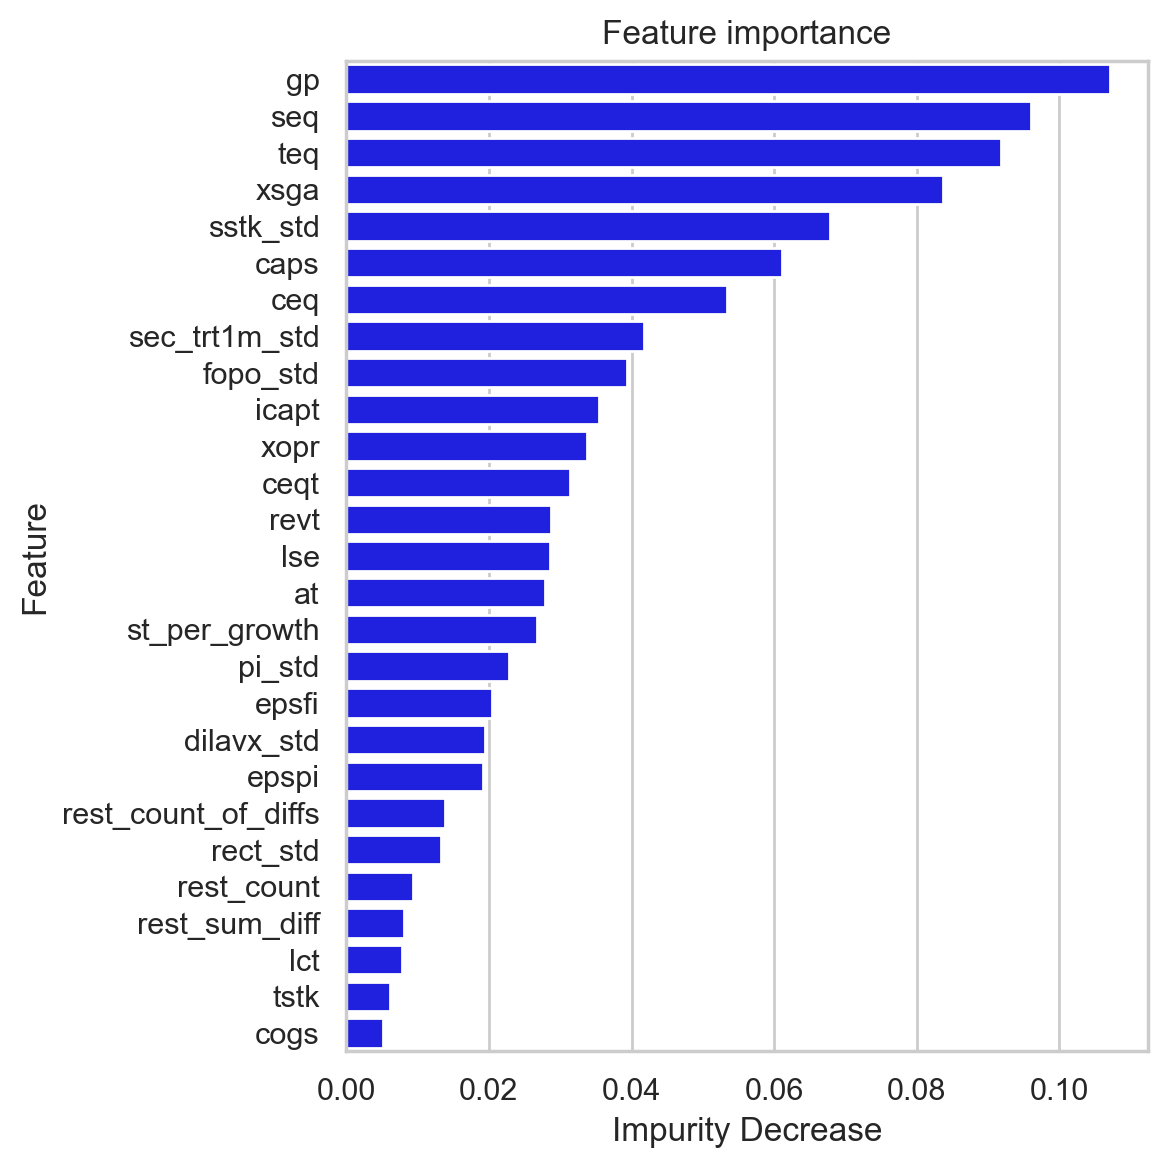

In [114]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance_FinalRound.png')

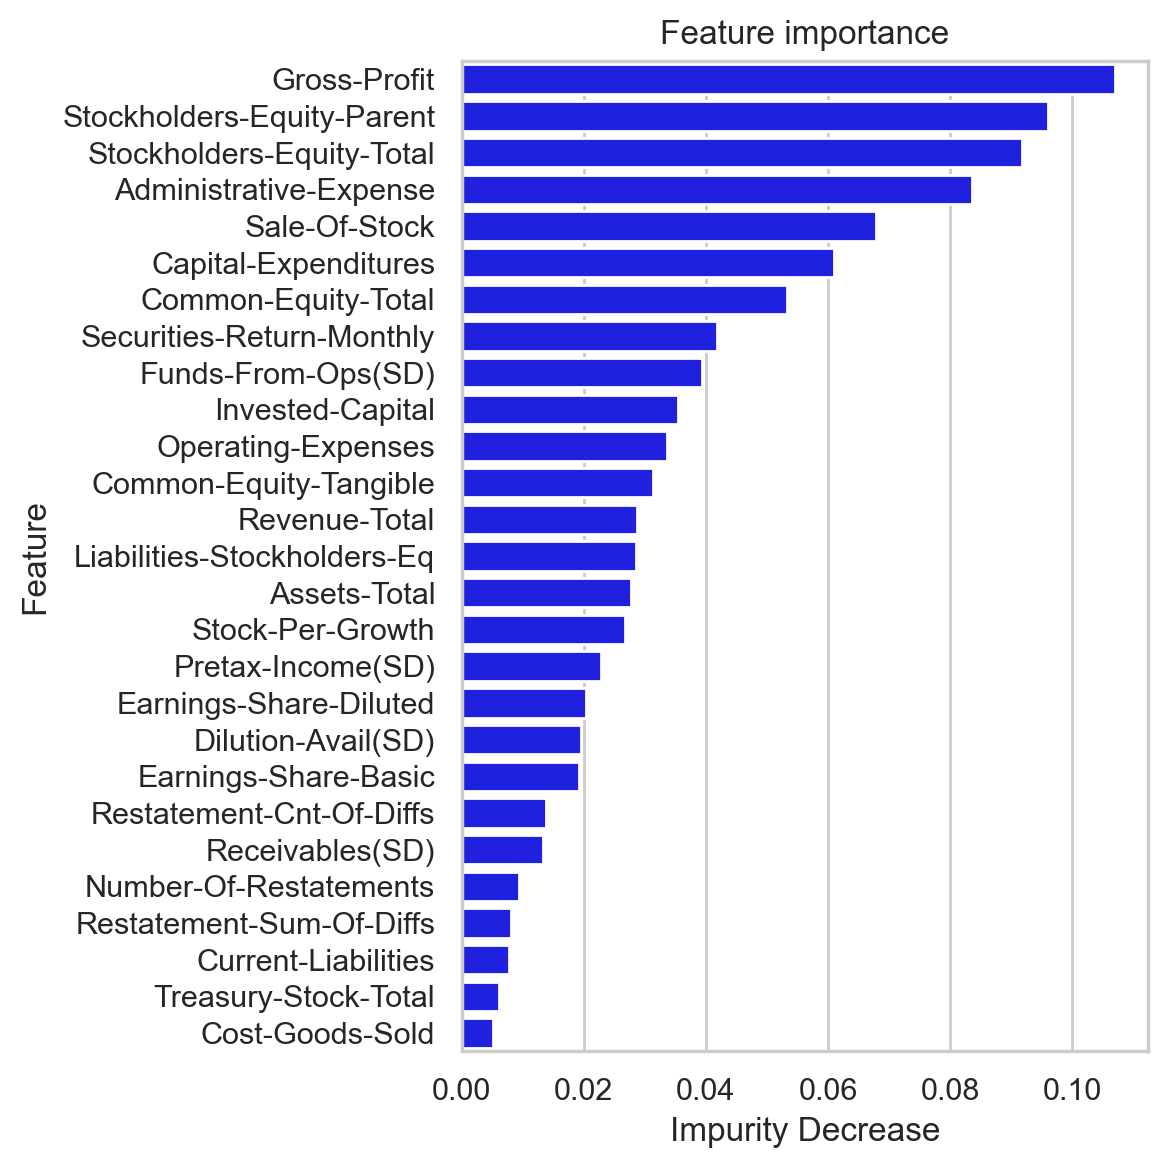

In [115]:
# Create Human Readable Feature Names For Feature Importance Plot
featureListDF = x_train
featureListDF = featureListDF.rename(columns={'at':'Assets-Total',
                                              'caps':'Capital-Expenditures',
                                              'ceq':'Common-Equity-Total',
                                              'ceqt':'Common-Equity-Tangible',
                                              'cogs':'Cost-Goods-Sold',
                                              'dilavx_std':'Dilution-Avail(SD)',
                                              'fopo_std':'Funds-From-Ops(SD)',
                                              'gp':'Gross-Profit',
                                              'icapt':'Invested-Capital',
                                              'lct':'Current-Liabilities',
                                              'lse':'Liabilities-Stockholders-Eq',
                                              'pi_std':'Pretax-Income(SD)',
                                              'rect_std':'Receivables(SD)',
                                              'rest_count_of_diffs':'Restatement-Cnt-Of-Diffs',
                                              'rest_sum_diff':'Restatement-Sum-Of-Diffs',
                                              'rest_count':'Number-Of-Restatements',
                                              'revt':'Revenue-Total',
                                              'sec_trt1m_std':'Securities-Return-Monthly',
                                              'seq':'Stockholders-Equity-Parent',
                                              'sstk_std':'Sale-Of-Stock',
                                              'st_per_growth':'Stock-Per-Growth',
                                              'teq':'Stockholders-Equity-Total',
                                              'tstk':'Treasury-Stock-Total',
                                              'xopr':'Operating-Expenses',
                                              'xsga':'Administrative-Expense',
                                              'epsfi':'Earnings-Share-Diluted',
                                              'epspi':'Earnings-Share-Basic',
                                              })

featureList = featureListDF.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance_FinalRound.png')



### Lawsuit -- Final Eval -- Voting Classifier

In [116]:
#create a dictionary of our models
estimators=[('RandFor',rf),('LogRef',lr3),('GNB',gnb),('ADA',ada)] # lr,rf,gnb
#parking lot: ('LogRef',lr),('RandFor',rf),('GNB',gnb),('ADA',ada)

#create our voting classifier, inputting our models
eclf = VotingClassifier(estimators,weights=[3,3,1,1],voting='soft') #

# fit model to training data
eclf.fit(x_train, y_train)

# Make Predictions
y_pred_eclf = eclf.predict(x_test)
print("done predict eclf")

done predict eclf


start eclf plot


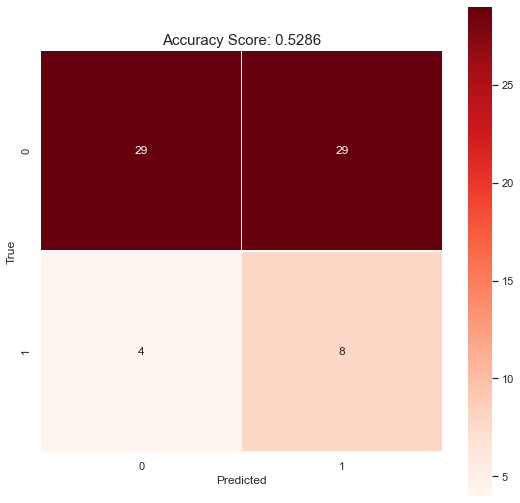

In [117]:
print("start eclf plot")
cm, score = createConfMatrix(eclf,y_test, y_pred_eclf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'eclf_CM.png')

In [118]:
# Voting Classifier -- Precision/Recall Scores

## Set Params
model_name = "-- Voting Classifier -- Final Eval --  RF4/LR4-3/GNB1/ADA1"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_eclf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

Model  Accuracy  Precision  \
0         Random Forest-Feature Selection-Tune=Recall    0.7286     0.2500   
1         Gradient Boost-FeatureSelection-Tune=Recall    0.7429     0.1818   
2       Logistic Regression -- Second Eval - Untunned    0.6143     0.2000   
3          Random Forest -- Second Eval - Tune=Recall    0.5714     0.1786   
4              ADA Boosting  -- Second Eval - Untuned    0.4143     0.1463   
5                  LDA -- Second Eval - Tuning=Recall    0.6857     0.2222   
6                  Classification Tree -- Second Eval    0.6286     0.1500   
7                                          GaussianNB    0.3571     0.1765   
8                   Logistic Regression -- Third Eval    0.5429     0.1667   
9   Random Forest -- Third Eval - w/oFeatures<0.1 ...    0.5429     0.1667   
10  -- Voting Classifier -- Final Eval --  RF4/LR4...    0.5286     0.2162   

    Recall      F1                  CM  
0   0.3636  0.2963  [[47, 12], [7, 4]]  
1   0.1818  0.1818   [[50, 9], [9, 2]]  
2   0.4167  0.2703  [[38, 20], [7, 5]]  
3   0.4167  0.2500  [[35, 23], [7, 5]]  
4   0.5000  0.2264  [[23, 35], [6, 6]]  
5   0.3333  0.2667  [[44, 14], [8, 4]]  
6   0.2500  0.1875  [[41, 17], [9, 3]]  
7   0.7500  0.2857  [[16, 42], [3, 9]]  
8   0.4167  0.2381  [[33, 25], [7, 5]]  
9   0.4167  0.2381  [[33, 25], [7, 5]]  
10  0.6667  0.3265  [[29, 29], [4, 8]]

Start Ensemble ROC Plot


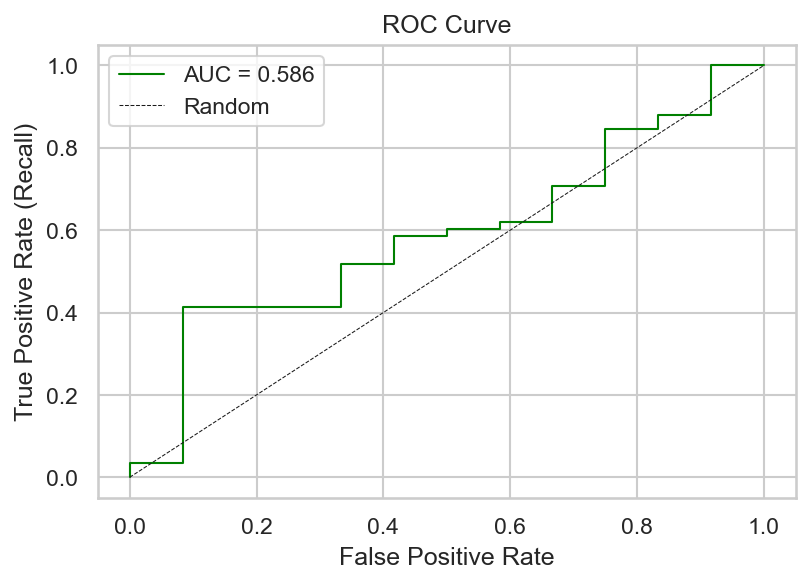

<Figure size 432x288 with 0 Axes>

In [119]:
# ROC Curve/ AUC Score
print("Start Ensemble ROC Plot")

## Call Function
ROC_Curve_Plot(eclf,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'eclf_ROC.png')

# Scoring for Boston Beer Company

In [120]:
# Drop Model Specific Features from Above (need to review features dropped in final model eval)
colsToDrop = ['rat_spcsrc']
ls_Modeling_SAM = ls_Modeling_SAM.drop(columns=colsToDrop)

# Split Boston Beer Company into X/Y
x_bbc = ls_Modeling_SAM
x_bbc = x_bbc.drop(columns=('lawsuit'))
y_bbc = ls_Modeling_SAM['lawsuit']

In [121]:
# Make Predictions
y_pred_bbc = eclf.predict(x_bbc)
print("done predict eclf")

done predict eclf


start eclf plot


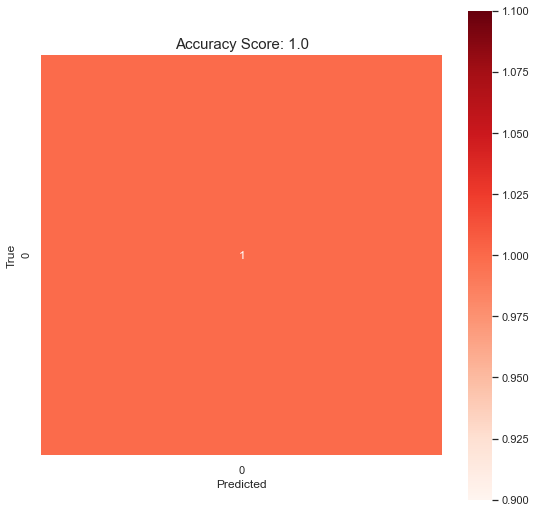

In [122]:
print("start eclf plot")
cm, score = createConfMatrix(eclf,y_bbc, y_pred_bbc, x_bbc) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'eclf_CM.png')

In [123]:
# Find Probability:
predicted_proba_sam = pd.DataFrame(eclf.predict_proba(x_bbc))
print(f"Predicted Probability of BBC Lawsuit:", predicted_proba_sam[1])

Predicted Probability of BBC Lawsuit: 0    0.341818
Name: 1, dtype: float64


In [124]:
predicted_proba_sam



0         1
0  0.658182  0.341818

# General Stats for Summary

All Stats Absent of Boston Beer Company -- In Other Words Looking at all other Companies


In [125]:
# Make Complete X/Y
# Drop Model Specific Features from Above (need to review features dropped in final model eval)
colsToDrop = ['rat_spcsrc']
ls_Modeling_stats = ls_Modeling.drop(columns=colsToDrop)
ls_Modeling_stats = pd.concat([ls_Modeling_stats,ls_Modeling_SAM])

#Create Column for Boston Beer Company
#ls_Modeling_stats['bbc'] = 0
#ls_Modeling_stats.loc[61581,['bbc']] = [1]

## Split Boston Beer Company into Complete X/Y:
x_all = ls_Modeling_stats
x_all = x_all.drop(columns=('lawsuit'))
y_all = ls_Modeling['lawsuit']

## Split Boston Beer Company into Positive Class X/Y:
x_pos = ls_Modeling_stats
x_pos = x_pos[x_pos['lawsuit'] == 1]
x_pos = x_pos.drop(columns=('lawsuit'))
y_pos = ls_Modeling['lawsuit']

## Split Boston Beer Company into Positive Class X/Y:
x_neg = ls_Modeling_stats
x_neg = x_neg[x_neg['lawsuit'] == 0]
x_neg = x_neg.drop(columns=('lawsuit'))
y_neg = ls_Modeling['lawsuit']


In [126]:
# Number of Companies:
numOFComp = len(x_all)
print(f"Number of Companies:",numOFComp)
print()

# Number of Lawsuits in Industry Section:
print(f"Companies with Lawsuits:\n",ls_Modeling_stats['lawsuit'].value_counts())
print()

# Find Average Probability for Lawsuit -- Known Negative Class:
predicted_proba_neg = pd.DataFrame(eclf.predict_proba(x_neg))
predicted_proba_neg = predicted_proba_neg[1]

## get Percentiles:
negClass25 = round(predicted_proba_neg.quantile(0.25),2) # 25th percentile
negClassMean = round(predicted_proba_neg.mean(),2)
negClass75 = round(predicted_proba_neg.quantile(0.75),2) # 25th percentile
print(f"Negative Class -- 25th Percentile:",negClass25,"Median:",negClassMean,"75th Percentile:",negClass75)

# Find Average Probability for Lawsuit -- Known Postive Class:
predicted_proba_pos = pd.DataFrame(eclf.predict_proba(x_pos))
predicted_proba_pos = predicted_proba_pos[1]

## get Percentiles:
posClass25 = round(predicted_proba_pos.quantile(0.25),2) # 25th percentile
posClassMean = round(predicted_proba_pos.mean(),2)
posClass75 = round(predicted_proba_pos.quantile(0.75),2) # 25th percentile
print(f"Postive Class -- 25th Percentile:",posClass25,"Median:",posClassMean,"75th Percentile:",posClass75)

## Get Percentile for Boston Beer Company:
from scipy.stats import percentileofscore
predicted_proba_all = pd.DataFrame(eclf.predict_proba(x_all))
predicted_proba_all = predicted_proba_all[1]

percentile_of_Sam = percentileofscore(predicted_proba_all, 0.302864) # Value from prediction above
print(f"Percentile of Probability for Boston Beer Works:",percentile_of_Sam)

Number of Companies: 348

Companies with Lawsuits:
 0    302
1     46
Name: lawsuit, dtype: int64

Negative Class -- 25th Percentile: 0.23 Median: 0.39 75th Percentile: 0.56
Postive Class -- 25th Percentile: 0.54 Median: 0.63 75th Percentile: 0.76
Percentile of Probability for Boston Beer Works: 34.770114942528735


## Visuals

In [127]:
x_all


at      caps      ceq     ceqt     cogs  dilavx_std  fopo_std  \
gvkey                                                                        
1239   -0.24066 -0.107420 -0.13824  0.11416 -0.21536   -0.007951  -0.14491   
1266   -0.32871 -0.217020 -0.28943  0.01059 -0.24745   -0.316800  -0.31462   
1408    0.10983 -0.019370  0.30302 -0.05080 -0.20541    0.104840   0.00032   
1429   -0.29217 -0.181038 -0.27058  0.04073 -0.19786   -0.321149  -0.31598   
1659   -0.23650 -0.178050 -0.23423  0.08879 -0.03254   -0.305800  -0.29361   
...         ...       ...      ...      ...      ...         ...       ...   
222519 -0.17066 -0.219130 -0.18932  0.12787 -0.11840    0.121740  -0.02298   
241637  5.82959  3.916780  4.62649 -7.84982  0.41715   13.198870  12.14122   
264393 -0.33830 -0.217980 -0.30452 -0.01358 -0.25023   -0.338700  -0.30930   
277487 -0.31938 -0.218880 -0.26947  0.04224 -0.24817   -0.320980  -0.28439   
61581  -0.32199 -0.185500 -0.27741  0.02942 -0.23981   -0.319740  -0.30950   

             gp    icapt      lct  ...  sec_trt1m_std      seq  sstk_std  \
gvkey                              ...                                     
1239   -0.19341 -0.20966 -0.26600  ...      -0.149950 -0.13920  0.233046   
1266   -0.29033 -0.31823 -0.31737  ...      -0.145000 -0.29129 -0.339700   
1408   -0.11174  0.23814 -0.13366  ...      -0.149870  0.30339  0.230410   
1429   -0.24584 -0.29247 -0.25970  ...       0.070996 -0.26755 -0.339700   
1659   -0.24763 -0.25695 -0.14672  ...      -0.145310 -0.23589 -0.334990   
...         ...      ...      ...  ...            ...      ...       ...   
222519 -0.13162 -0.15822 -0.16329  ...      -0.142180 -0.19081 -0.339700   
241637  2.67914  6.52764  3.46539  ...      -0.150770  4.64312  0.298960   
264393 -0.29351 -0.33249 -0.31875  ...      -0.112800 -0.30643 -0.339700   
277487 -0.29102 -0.30717 -0.30915  ...      -0.146100 -0.27126 -0.339700   
61581  -0.25679 -0.31453 -0.30435  ...      -0.145460 -0.27923 -0.326470   

        st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  
gvkey                                                                          
1239           0.2500 -0.14483 -0.18762 -0.20887 -0.16900 -0.051470 -0.051130  
1266           0.3300 -0.29206 -0.18747 -0.25727 -0.27027 -0.047800 -0.048080  
1408           9.3600  0.28364  0.44655 -0.19359 -0.13639 -0.026060 -0.025610  
1429           4.1935 -0.26382 -0.18762 -0.20674 -0.22145 -0.001225  0.000962  
1659           1.0800 -0.23648 -0.18483 -0.07718 -0.23121  0.010280  0.010730  
...               ...      ...      ...      ...      ...       ...       ...  
222519         5.3300 -0.17209 -0.18762 -0.11807 -0.10128 -0.054730 -0.055010  
241637         1.1100  4.96328 -0.12116  0.68968  1.58098  0.000620  0.001600  
264393         1.0000 -0.30672 -0.18762 -0.25968 -0.27112 -0.084240 -0.084520  
277487        -0.2500 -0.27267 -0.18762 -0.25755 -0.26855 -0.080880 -0.081160  
61581          3.7700 -0.28038 -0.18762 -0.24342 -0.23582  0.012380  0.017140  

[348 rows x 27 columns]

In [168]:
# Drop bbc indictor column from x_all


# Make Predictions DF
y_pred_viz = eclf.predict_proba(x_all)
predictions_pred = pd.DataFrame(y_pred_viz)
predictions_pred = predictions_pred[1]
predictions_pred

0      0.708313
1      0.433416
2      0.481991
3      0.259554
4      0.448653
         ...   
343    0.296995
344    0.226253
345    0.265850
346    0.380398
347    0.341818
Name: 1, Length: 348, dtype: float64

In [169]:
# Make DF for Predictor Values
predictions_x = x_all
predictions_x = predictions_x.reset_index()
predictions_x

gvkey       at      caps      ceq     ceqt     cogs  dilavx_std  \
0      1239 -0.24066 -0.107420 -0.13824  0.11416 -0.21536   -0.007951   
1      1266 -0.32871 -0.217020 -0.28943  0.01059 -0.24745   -0.316800   
2      1408  0.10983 -0.019370  0.30302 -0.05080 -0.20541    0.104840   
3      1429 -0.29217 -0.181038 -0.27058  0.04073 -0.19786   -0.321149   
4      1659 -0.23650 -0.178050 -0.23423  0.08879 -0.03254   -0.305800   
..      ...      ...       ...      ...      ...      ...         ...   
343  222519 -0.17066 -0.219130 -0.18932  0.12787 -0.11840    0.121740   
344  241637  5.82959  3.916780  4.62649 -7.84982  0.41715   13.198870   
345  264393 -0.33830 -0.217980 -0.30452 -0.01358 -0.25023   -0.338700   
346  277487 -0.31938 -0.218880 -0.26947  0.04224 -0.24817   -0.320980   
347   61581 -0.32199 -0.185500 -0.27741  0.02942 -0.23981   -0.319740   

     fopo_std       gp    icapt  ...  sec_trt1m_std      seq  sstk_std  \
0    -0.14491 -0.19341 -0.20966  ...      -0.149950 -0.13920  0.233046   
1    -0.31462 -0.29033 -0.31823  ...      -0.145000 -0.29129 -0.339700   
2     0.00032 -0.11174  0.23814  ...      -0.149870  0.30339  0.230410   
3    -0.31598 -0.24584 -0.29247  ...       0.070996 -0.26755 -0.339700   
4    -0.29361 -0.24763 -0.25695  ...      -0.145310 -0.23589 -0.334990   
..        ...      ...      ...  ...            ...      ...       ...   
343  -0.02298 -0.13162 -0.15822  ...      -0.142180 -0.19081 -0.339700   
344  12.14122  2.67914  6.52764  ...      -0.150770  4.64312  0.298960   
345  -0.30930 -0.29351 -0.33249  ...      -0.112800 -0.30643 -0.339700   
346  -0.28439 -0.29102 -0.30717  ...      -0.146100 -0.27126 -0.339700   
347  -0.30950 -0.25679 -0.31453  ...      -0.145460 -0.27923 -0.326470   

     st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  
0           0.2500 -0.14483 -0.18762 -0.20887 -0.16900 -0.051470 -0.051130  
1           0.3300 -0.29206 -0.18747 -0.25727 -0.27027 -0.047800 -0.048080  
2           9.3600  0.28364  0.44655 -0.19359 -0.13639 -0.026060 -0.025610  
3           4.1935 -0.26382 -0.18762 -0.20674 -0.22145 -0.001225  0.000962  
4           1.0800 -0.23648 -0.18483 -0.07718 -0.23121  0.010280  0.010730  
..             ...      ...      ...      ...      ...       ...       ...  
343         5.3300 -0.17209 -0.18762 -0.11807 -0.10128 -0.054730 -0.055010  
344         1.1100  4.96328 -0.12116  0.68968  1.58098  0.000620  0.001600  
345         1.0000 -0.30672 -0.18762 -0.25968 -0.27112 -0.084240 -0.084520  
346        -0.2500 -0.27267 -0.18762 -0.25755 -0.26855 -0.080880 -0.081160  
347         3.7700 -0.28038 -0.18762 -0.24342 -0.23582  0.012380  0.017140  

[348 rows x 28 columns]

In [172]:
topfeatures = ['gvkey','lawsuit_prediction','gp','xsga','seq','teq','sstk_std','caps','ceq','rest_count']

predictions = pd.merge(predictions_pred, predictions_x, left_index=True, right_index=True)
predictions = predictions.rename(columns={1:"lawsuit_prediction"})
predictions = predictions.set_index('gvkey')
predictions

lawsuit_prediction       at      caps      ceq     ceqt     cogs  \
gvkey                                                                      
1239              0.708313 -0.24066 -0.107420 -0.13824  0.11416 -0.21536   
1266              0.433416 -0.32871 -0.217020 -0.28943  0.01059 -0.24745   
1408              0.481991  0.10983 -0.019370  0.30302 -0.05080 -0.20541   
1429              0.259554 -0.29217 -0.181038 -0.27058  0.04073 -0.19786   
1659              0.448653 -0.23650 -0.178050 -0.23423  0.08879 -0.03254   
...                    ...      ...       ...      ...      ...      ...   
222519            0.296995 -0.17066 -0.219130 -0.18932  0.12787 -0.11840   
241637            0.226253  5.82959  3.916780  4.62649 -7.84982  0.41715   
264393            0.265850 -0.33830 -0.217980 -0.30452 -0.01358 -0.25023   
277487            0.380398 -0.31938 -0.218880 -0.26947  0.04224 -0.24817   
61581             0.341818 -0.32199 -0.185500 -0.27741  0.02942 -0.23981   

        dilavx_std  fopo_std       gp    icapt  ...  sec_trt1m_std      seq  \
gvkey                                           ...                           
1239     -0.007951  -0.14491 -0.19341 -0.20966  ...      -0.149950 -0.13920   
1266     -0.316800  -0.31462 -0.29033 -0.31823  ...      -0.145000 -0.29129   
1408      0.104840   0.00032 -0.11174  0.23814  ...      -0.149870  0.30339   
1429     -0.321149  -0.31598 -0.24584 -0.29247  ...       0.070996 -0.26755   
1659     -0.305800  -0.29361 -0.24763 -0.25695  ...      -0.145310 -0.23589   
...            ...       ...      ...      ...  ...            ...      ...   
222519    0.121740  -0.02298 -0.13162 -0.15822  ...      -0.142180 -0.19081   
241637   13.198870  12.14122  2.67914  6.52764  ...      -0.150770  4.64312   
264393   -0.338700  -0.30930 -0.29351 -0.33249  ...      -0.112800 -0.30643   
277487   -0.320980  -0.28439 -0.29102 -0.30717  ...      -0.146100 -0.27126   
61581    -0.319740  -0.30950 -0.25679 -0.31453  ...      -0.145460 -0.27923   

        sstk_std  st_per_growth      teq     tstk     xopr     xsga     epsfi  \
gvkey                                                                           
1239    0.233046         0.2500 -0.14483 -0.18762 -0.20887 -0.16900 -0.051470   
1266   -0.339700         0.3300 -0.29206 -0.18747 -0.25727 -0.27027 -0.047800   
1408    0.230410         9.3600  0.28364  0.44655 -0.19359 -0.13639 -0.026060   
1429   -0.339700         4.1935 -0.26382 -0.18762 -0.20674 -0.22145 -0.001225   
1659   -0.334990         1.0800 -0.23648 -0.18483 -0.07718 -0.23121  0.010280   
...          ...            ...      ...      ...      ...      ...       ...   
222519 -0.339700         5.3300 -0.17209 -0.18762 -0.11807 -0.10128 -0.054730   
241637  0.298960         1.1100  4.96328 -0.12116  0.68968  1.58098  0.000620   
264393 -0.339700         1.0000 -0.30672 -0.18762 -0.25968 -0.27112 -0.084240   
277487 -0.339700        -0.2500 -0.27267 -0.18762 -0.25755 -0.26855 -0.080880   
61581  -0.326470         3.7700 -0.28038 -0.18762 -0.24342 -0.23582  0.012380   

           epspi  
gvkey             
1239   -0.051130  
1266   -0.048080  
1408   -0.025610  
1429    0.000962  
1659    0.010730  
...          ...  
222519 -0.055010  
241637  0.001600  
264393 -0.084520  
277487 -0.081160  
61581   0.017140  

[348 rows x 28 columns]

In [173]:
# Re-add BBC Indicator
predictions['bbc'] = 0
predictions.loc[61581,['bbc']] = [1]
predictions


lawsuit_prediction       at      caps      ceq     ceqt     cogs  \
gvkey                                                                      
1239              0.708313 -0.24066 -0.107420 -0.13824  0.11416 -0.21536   
1266              0.433416 -0.32871 -0.217020 -0.28943  0.01059 -0.24745   
1408              0.481991  0.10983 -0.019370  0.30302 -0.05080 -0.20541   
1429              0.259554 -0.29217 -0.181038 -0.27058  0.04073 -0.19786   
1659              0.448653 -0.23650 -0.178050 -0.23423  0.08879 -0.03254   
...                    ...      ...       ...      ...      ...      ...   
222519            0.296995 -0.17066 -0.219130 -0.18932  0.12787 -0.11840   
241637            0.226253  5.82959  3.916780  4.62649 -7.84982  0.41715   
264393            0.265850 -0.33830 -0.217980 -0.30452 -0.01358 -0.25023   
277487            0.380398 -0.31938 -0.218880 -0.26947  0.04224 -0.24817   
61581             0.341818 -0.32199 -0.185500 -0.27741  0.02942 -0.23981   

        dilavx_std  fopo_std       gp    icapt  ...      seq  sstk_std  \
gvkey                                           ...                      
1239     -0.007951  -0.14491 -0.19341 -0.20966  ... -0.13920  0.233046   
1266     -0.316800  -0.31462 -0.29033 -0.31823  ... -0.29129 -0.339700   
1408      0.104840   0.00032 -0.11174  0.23814  ...  0.30339  0.230410   
1429     -0.321149  -0.31598 -0.24584 -0.29247  ... -0.26755 -0.339700   
1659     -0.305800  -0.29361 -0.24763 -0.25695  ... -0.23589 -0.334990   
...            ...       ...      ...      ...  ...      ...       ...   
222519    0.121740  -0.02298 -0.13162 -0.15822  ... -0.19081 -0.339700   
241637   13.198870  12.14122  2.67914  6.52764  ...  4.64312  0.298960   
264393   -0.338700  -0.30930 -0.29351 -0.33249  ... -0.30643 -0.339700   
277487   -0.320980  -0.28439 -0.29102 -0.30717  ... -0.27126 -0.339700   
61581    -0.319740  -0.30950 -0.25679 -0.31453  ... -0.27923 -0.326470   

        st_per_growth      teq     tstk     xopr     xsga     epsfi     epspi  \
gvkey                                                                           
1239           0.2500 -0.14483 -0.18762 -0.20887 -0.16900 -0.051470 -0.051130   
1266           0.3300 -0.29206 -0.18747 -0.25727 -0.27027 -0.047800 -0.048080   
1408           9.3600  0.28364  0.44655 -0.19359 -0.13639 -0.026060 -0.025610   
1429           4.1935 -0.26382 -0.18762 -0.20674 -0.22145 -0.001225  0.000962   
1659           1.0800 -0.23648 -0.18483 -0.07718 -0.23121  0.010280  0.010730   
...               ...      ...      ...      ...      ...       ...       ...   
222519         5.3300 -0.17209 -0.18762 -0.11807 -0.10128 -0.054730 -0.055010   
241637         1.1100  4.96328 -0.12116  0.68968  1.58098  0.000620  0.001600   
264393         1.0000 -0.30672 -0.18762 -0.25968 -0.27112 -0.084240 -0.084520   
277487        -0.2500 -0.27267 -0.18762 -0.25755 -0.26855 -0.080880 -0.081160   
61581          3.7700 -0.28038 -0.18762 -0.24342 -0.23582  0.012380  0.017140   

        bbc  
gvkey        
1239      0  
1266      0  
1408      0  
1429      0  
1659      0  
...     ...  
222519    0  
241637    0  
264393    0  
277487    0  
61581     1  

[348 rows x 29 columns]

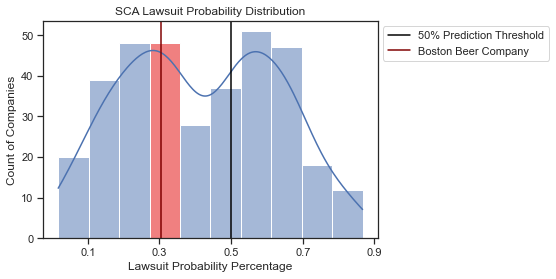

In [174]:
# Visual 1 -- Simple Risk Level Histplot
sns.set_theme(style="ticks")
ax =sns.histplot(data=predictions, x="lawsuit_prediction",
                 bins = 10,
                 kde=True,
             )
plt.ylabel("Count of Companies")
plt.xlabel("Lawsuit Probability Percentage")
plt.title("SCA Lawsuit Probability Distribution")
plt.xticks([0.1,0.3,0.5,0.7,0.9])
ax.patches[3].set_facecolor('lightcoral')
plt.axvline(0.5,label='50% Prediction Threshold',color='black')
plt.axvline(0.305,label='Boston Beer Company',color='maroon')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
#plt.show()

plt.savefig(plotLoc+'ProbDist.png')


<AxesSubplot:xlabel='lawsuit_prediction', ylabel='gp'>

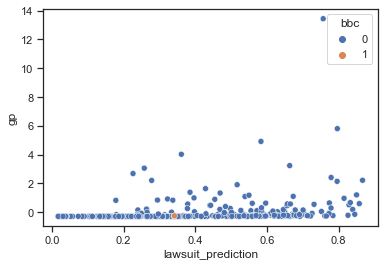

In [175]:
sns.set_theme(style="ticks")
sns.scatterplot(data=predictions, x="lawsuit_prediction", y="gp",
                hue='bbc',
                )

In [198]:
from treeinterpreter import treeinterpreter as ti

for i,row in x_bbc.iterrows():

    data_point = pd.DataFrame([row])
    data_point.set_axis(['value_variable']) # Once transposed, it will be the column name
    prediction, bias, contributions = ti.predict(rf, x_bbc)
    local_interpretation = data_point.append(
	    pd.DataFrame([[round(c[1],3) for c in contributions[0]]], columns=data_point.columns.tolist(), index=['contribution_variable'])
    ).T.sort_values('contribution_variable', ascending=False)
    print(local_interpretation)

                       61581  contribution_variable
gp                  -0.25679                  0.029
seq                 -0.27923                  0.026
teq                 -0.28038                  0.023
xsga                -0.23582                  0.022
sstk_std            -0.32647                  0.017
caps                -0.18550                  0.016
ceq                 -0.27741                  0.016
xopr                -0.24342                  0.010
lse                 -0.32199                  0.010
rect_std            -0.28992                  0.009
revt                -0.25257                  0.008
icapt               -0.31453                  0.008
sec_trt1m_std       -0.14546                  0.007
at                  -0.32199                  0.007
cogs                -0.23981                  0.006
lct                 -0.30435                  0.006
ceqt                 0.02942                  0.000
tstk                -0.18762                 -0.003
rest_sum_dif

In [199]:
local_interpretation = local_interpretation.rename(columns={61581:"FeatureValue",
                                                            "contribution_variable":"Contribution"})

local_interpretation['Contribution'] = round(local_interpretation['Contribution']*100,3)
local_interpretation = local_interpretation.sort_values(by=['Contribution'])

local_interpretation

FeatureValue  Contribution
st_per_growth             3.77000          -7.0
epsfi                     0.01238          -5.0
epspi                     0.01714          -4.0
fopo_std                 -0.30950          -2.8
dilavx_std               -0.31974          -2.0
pi_std                   -0.34775          -2.0
rest_count                0.00000          -1.3
rest_count_of_diffs       0.00000          -1.0
rest_sum_diff            -0.13080          -0.8
tstk                     -0.18762          -0.3
ceqt                      0.02942           0.0
lct                      -0.30435           0.6
cogs                     -0.23981           0.6
at                       -0.32199           0.7
sec_trt1m_std            -0.14546           0.7
icapt                    -0.31453           0.8
revt                     -0.25257           0.8
rect_std                 -0.28992           0.9
lse                      -0.32199           1.0
xopr                     -0.24342           1.0
ceq                      -0.27741           1.6
caps                     -0.18550           1.6
sstk_std                 -0.32647           1.7
xsga                     -0.23582           2.2
teq                      -0.28038           2.3
seq                      -0.27923           2.6
gp                       -0.25679           2.9

In [206]:
origDF

gvkey  exesign  src  auop   gsubind    aoloch  aoloch_std           at  \
0      1239        1    5     2  30302010    1.9000         NaN    1878.2750   
1      1266        1    5     1  30202010    1.2535    1.830697     186.9500   
2      1408        1    8     1  30201020  -45.6000   97.666281    8610.8000   
3      1429        1    3     1  30202030   24.1015   58.012527     888.7935   
4      1659        1    5     1  30101020    2.3535  175.842783    1958.2135   
..      ...      ...  ...   ...       ...       ...         ...          ...   
343  221545        1   53     2  30202030  -12.6520   25.701164    1937.4615   
344  222519        1   53     2  30202030   84.9260   90.800682    3222.9275   
345  241637        1   53     1  30201010  524.5000  318.249902  118481.5000   
346  264393        1    5     1  30101020   -0.1110    0.151167       2.7385   
347  277487        1    5     1  30202010   -4.8180    6.662282     366.2330   

           at_std    bkvlps  ...  st_volatility  sec_ajexm  sec_ajpm  \
0             NaN  13.40560  ...           0.14   1.000000  1.000000   
1        7.957660  16.20710  ...           0.27   1.000000  1.000000   
2     2280.693689  29.90630  ...           0.89   1.000000  1.000000   
3       68.170766       NaN  ...            NaN        NaN       NaN   
4      297.805866  30.10240  ...           0.29   1.453704  1.453704   
..            ...       ...  ...            ...        ...       ...   
343    286.230298  27.87360  ...           0.32   1.000000  1.000000   
344    306.367553   7.22880  ...           0.70   1.000000  1.000000   
345  13355.269946  24.57005  ...           0.28   1.000000  1.000000   
346      2.113443   0.06010  ...           1.49   0.473704  0.473704   
347     72.113035   4.76250  ...           0.19   1.000000  1.000000   

     sec_trfm_mean  sec_trfm_std  sec_trt1m_mean  sec_trt1m_std  rat_spcsrc  \
0         6.001949      0.026279        1.631413       6.320251         6.0   
1         1.803951      0.017539        0.991502       9.322428         3.0   
2        19.151070      2.316089        2.017711       6.373380         4.0   
3              NaN           NaN             NaN            NaN         0.0   
4         1.274316      0.020235        2.559811       9.131795         6.0   
..             ...           ...             ...            ...         ...   
343       1.756264      0.051788        1.996371       6.788384         0.0   
344       1.204377      0.000000        4.203464      11.024610         0.0   
345       1.043322      0.030272        1.827778       5.822912         0.0   
346       1.000000      0.000000        6.590749      28.817567         0.0   
347       1.001641      0.003915       -0.212626       8.650915         0.0   

     lawsuit  SettlementAmount  
0        1.0               0.0  
1        0.0               NaN  
2        0.0               NaN  
3        0.0               NaN  
4        0.0               NaN  
..       ...               ...  
343      0.0               NaN  
344      0.0               NaN  
345      0.0               NaN  
346      0.0               NaN  
347      0.0               NaN  

[348 rows x 162 columns]

In [221]:
bbc_orig = origDF.loc[origDF['gvkey'] == 61581]

varlist =['st_per_growth','epsfi','epspi','fopo_std','dilavx_std','rest_count',
          'caps','sstk_std','xsga','teq','seq','gp',
          ]

for var in varlist:
    groupMed = round(origDF[var].median(),4)
    BBCVal = round(bbc_orig[var].median(),4)
    print(f"For",var,"-- Group Mean:",groupMed,"-- BBC Value:",BBCVal)

For st_per_growth -- Group Mean: 0.2 -- BBC Value: 3.77
For epsfi -- Group Mean: 0.375 -- BBC Value: 4.6
For epspi -- Group Mean: 0.38 -- BBC Value: 4.84
For fopo_std -- Group Mean: 4.6071 -- BBC Value: 2.0059
For dilavx_std -- Group Mean: 10.3823 -- BBC Value: 8.695
For rest_count -- Group Mean: 1.0 -- BBC Value: 0.0
For caps -- Group Mean: 39.1845 -- BBC Value: 147.8205
For sstk_std -- Group Mean: 1.2351 -- BBC Value: 1.2947
For xsga -- Group Mean: 60.192 -- BBC Value: 210.1115
For teq -- Group Mean: 103.9387 -- BBC Value: 214.918
For seq -- Group Mean: 103.9387 -- BBC Value: 214.918
For gp -- Group Mean: 102.8615 -- BBC Value: 319.2425


['at',
 'caps',
 'ceq',
 'ceqt',
 'cogs',
 'dilavx_std',
 'fopo_std',
 'gp',
 'icapt',
 'lct',
 'lse',
 'pi_std',
 'rect_std',
 'rest_count_of_diffs',
 'rest_sum_diff',
 'rest_count',
 'revt',
 'sec_trt1m_std',
 'seq',
 'sstk_std',
 'st_per_growth',
 'teq',
 'tstk',
 'xopr',
 'xsga',
 'epsfi',
 'epspi']

# Exports

In [222]:
# Export Cleaned Data to CSV:

# Export Clean Actions Report:
qe_summaryDF.to_excel(exportPath+"LS_Model-Quick-Eval.xlsx")
cleanActionsDF.to_excel(exportPath+"Clean_Actions_Report_Modeling.xlsx")
feature_importances_summary.to_excel(exportPath+"FeatureImportance_Summary.xlsx")
summaryDF.to_excel(exportPath+"Model-Perf_Summary_v5.xlsx")
ls_Modeling.to_excel(exportPath+"Clean_Modeling_Data.xlsx")
print("Done")

Done


# Model Tuning

In [137]:
#break

## ADA Boosting Tuning -- Recall

In [138]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.001,
 'n_estimators': 100,
 'random_state': 0}

In [139]:
clf = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50,100,200,500],
    'learning_rate': [0.001,0.01,0.1,0.2,0.5,1.0],
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [140]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

ADA_Best_Params = grid_search_clf.best_params_

# Write REport
ADA_Best_Params = {'exDict': ADA_Best_Params}

with open('ADA_Best_Params_ThirdEval_Recall.txt', 'w') as file:
     file.write(json.dumps(ADA_Best_Params))
print("done")

starting...
Best params for recall_score
{'learning_rate': 0.001, 'n_estimators': 50}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        18        40
pos         3         9
done


In [141]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

done


In [142]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

done


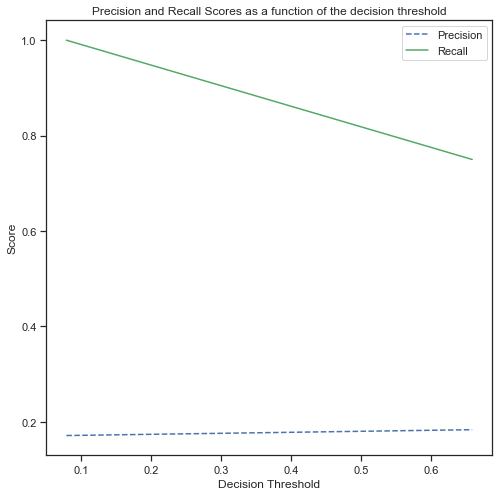

In [143]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.savefig(plotLoc +'ADA_Decision-Thresh.png')

In [144]:
break

SyntaxError: 'break' outside loop (<ipython-input-144-d96a1d1b8682>, line 1)

## RF Tuning -- Recall

In [ ]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [3,5,10,20],
    'n_estimators': [100,500,1000],
    'max_leaf_nodes':[16,32,64,96],
    'criterion':['gini','entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

RF_Best_Params = grid_search_clf.best_params_

# Write REport
RF_Best_Params = {'exDict': RF_Best_Params}

with open('RF_Best_Params_ThirdEval_Recall.txt', 'w') as file:
     file.write(json.dumps(RF_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

In [ ]:
break

## RF Tuning -- Accuracy

In [ ]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [3,5,10,20],
    'n_estimators': [100,500,1000],
    'max_leaf_nodes':[16,32,64,96],
    'criterion':['gini','entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf

RF_Best_Params = grid_search_clf.best_params_

# Write REport
RF_Best_Params = {'exDict': RF_Best_Params}

with open('RF_Best_Params_FeatSelect_Acc.txt', 'w') as file:
     file.write(json.dumps(RF_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')


## GB Tuning

In [ ]:
gb.get_params(deep=True)

In [ ]:
clf = GradientBoostingClassifier(verbose=2)

param_grid = {
    'min_samples_split': [10,50,75],
    'n_estimators' : [20,50,100],
    'max_depth': [3,6,10],
    'max_features': [4,8,10],
    'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.99]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
print("ready2")

In [ ]:
print("running2...")
refit_score='recall_score'
grid_search_clf = grid_search_wrapper(refit_score)
grid_search_clf

GB_Best_Params = grid_search_clf.best_params_

print("printing...")

# as requested in comment
GB_Best_Params = {'exDict': GB_Best_Params}

with open('GB_Best_Params_FeatSelect_Recall.txt', 'w') as file:
     file.write(json.dumps(GB_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'GB_Decision-Thresh.png')


## KNN Tuning -- Accuracy

In [ ]:
clf = KNeighborsClassifier(algorithm='auto')

param_grid = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("running2...")
refit_score='accuracy_score'
grid_search_clf = grid_search_wrapper(refit_score)
grid_search_clf

KNN_Best_Params = grid_search_clf.best_params_

print("printing...")

# as requested in comment
KNN_Best_Params = {'exDict': KNN_Best_Params}

with open('KNN_Best_Params_Acc.txt', 'w') as file:
     file.write(json.dumps(KNN_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'GB_Decision-Thresh.png')

## KNN Tuning -- Recall

In [ ]:
clf = KNeighborsClassifier(algorithm='auto')

param_grid = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

KNN_Best_Params = grid_search_clf.best_params_

# Write REport
KNN_Best_Params = {'exDict': KNN_Best_Params}

with open('KNN_Best_Params_Recall.txt', 'w') as file:
     file.write(json.dumps(KNN_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## LDA Tuning -- Accuracy

In [ ]:
clf = LinearDiscriminantAnalysis(shrinkage='auto')

param_grid = {
    'solver': ('lsqr','eigen'),
    'n_components': (1,5,1),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf

lda_Best_Params = grid_search_clf.best_params_

# Write REport
lda_Best_Params = {'exDict': lda_Best_Params}

with open('lda_Best_Params_Acc.txt', 'w') as file:
     file.write(json.dumps(lda_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## LDA Tuning -- Recall

In [ ]:
clf = LinearDiscriminantAnalysis(shrinkage='auto')

param_grid = {
    'solver': ('lsqr','eigen'),
    'n_components': (1,5,1),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

lda_Best_Params = grid_search_clf.best_params_

# Write REport
lda_Best_Params = {'exDict': lda_Best_Params}

with open('lda_Best_Params_Recall.txt', 'w') as file:
     file.write(json.dumps(lda_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## Classification Tree Tuning -- Accuracy

In [ ]:
clf = tree.DecisionTreeClassifier()

param_grid = {
    'criterion': ('gini','entropy'),
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,10),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf

cTree_Best_Params = grid_search_clf.best_params_

# Write REport
cTree_Best_Params = {'exDict': cTree_Best_Params}

with open('cTree_Best_Params_Acc.txt', 'w') as file:
     file.write(json.dumps(cTree_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## Classification Tree Tuning -- Recall

In [ ]:
clf = tree.DecisionTreeClassifier()

param_grid = {
    'criterion': ('gini','entropy'),
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,10),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

cTree_Best_Params = grid_search_clf.best_params_

# Write REport
cTree_Best_Params = {'exDict': cTree_Best_Params}

with open('cTree_Best_Params_Acc.txt', 'w') as file:
     file.write(json.dumps(cTree_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')


